In [2]:
#import required packages
import math
import torch
import torch.nn as nn
import numpy as np
import torch.nn.functional as F
from torch.optim.lr_scheduler import ReduceLROnPlateau
import json
from time import time
import argparse 
import sys
sys.argv=['']
import os
import h5py
from torch.utils.data import DataLoader, TensorDataset,random_split
import glob
import natsort
from PIL import Image
#import matplotlib.pyplot as plt
import time
import numpy as np
import torchvision.transforms as T
from torchvision import datasets
from torchvision.utils import make_grid
from torchvision.utils import save_image
import random
#from tools import *
#from wake_model_WITH_ERRORS import *
import PIL.ImageOps
import pandas as pd
from torchsummary import summary

In [2]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"
import matplotlib.pyplot as plt

### Network

In [3]:

#Convolutional layers in the dense blocks

class conv_layer(nn.Module):
    def __init__(self,init_features,k_size,p,growth_rate,bn_size,drop_out,bottleneck):
        super(). __init__()
        if bottleneck and init_features>growth_rate*bn_size:
            self.conv=nn.Sequential(
                nn.BatchNorm2d(init_features),
                nn.ReLU(inplace='True'),
                nn.Conv2d(init_features,growth_rate*bn_size,kernel_size=1,stride=1,padding=0,bias=False),
                nn.BatchNorm2d(growth_rate*bn_size),
                nn.ReLU(inplace='True'),
                nn.Conv2d(growth_rate*bn_size,growth_rate,kernel_size=k_size,stride=1,padding=p,bias=False)
            )
        else:
            self.conv=nn.Sequential(
                nn.BatchNorm2d(init_features),
                nn.ReLU(inplace='True'),
                nn.Conv2d(init_features,growth_rate,kernel_size=k_size,stride=1,padding=p,bias=False)
            )
        self.drop_out=drop_out
        
    def forward(self,x):
        out=self.conv(x)
        if self.drop_out>0:
            out = F.dropout(out, p=self.drop_out)
        return torch.cat([x,out],1)
            
class Dense_block(nn.Module):
    def __init__(self,init_features,conv_layer,k_size,p,n_layers,growth_rate,bn_size,drop_out,bottleneck):
        super().__init__()
        self.layer = self._make_layer(init_features,k_size,p,n_layers,conv_layer,growth_rate,bn_size,drop_out,bottleneck)
    def _make_layer(self,init_features,k_size,p,n_layers,conv_layer,growth_rate,bn_size,drop_out,bottleneck):
        layers=[]
        for i in range(n_layers):
            layers.append(conv_layer(init_features+i*growth_rate,k_size,p,growth_rate,bn_size,drop_out,bottleneck))
        return nn.Sequential(*layers)
    def forward(self, x):
        return self.layer(x)
    
class Encode_Decode(nn.Module):
    def __init__(self,init_features,out_features,k_size,p,growth_rate,drop_out,down,bottleneck,output_padding):
        super().__init__()
        self.drop_out=drop_out
        if down:
            if bottleneck:
                self.block1=nn.Sequential(nn.BatchNorm2d(init_features),
                    nn.ReLU(inplace=True),
                    nn.Conv2d(init_features,out_features,kernel_size=1,stride=1,padding=0,bias=False),
                    nn.BatchNorm2d(out_features),
                    nn.ReLU(inplace=True),
                    nn.Conv2d(out_features,out_features,kernel_size=k_size,stride=2,padding=p,bias=False)
                    )
            else:
                self.block1=nn.Sequential(nn.BatchNorm2d(init_features),
                    nn.ReLU(inplace=True),
                    nn.Conv2d(init_features,out_features,kernel_size=k_size,stride=2,padding=p,bias=False)
                    )
        else:
            if bottleneck:
                self.block1=nn.Sequential(nn.BatchNorm2d(init_features),
                    nn.ReLU(inplace=True),
                    nn.Conv2d(init_features,out_features,kernel_size=1,stride=1,padding=0,bias=False),
                    nn.BatchNorm2d(out_features),
                    nn.ReLU(inplace=True),
                    nn.ConvTranspose2d(out_features,out_features,kernel_size=k_size,stride=2,padding=p,output_padding=output_padding,bias=False)
                    )
                
            else:
                self.block1=nn.Sequential(nn.BatchNorm2d(init_features),
                    nn.ReLU(inplace=True),
                    nn.ConvTranspose2d(out_features,out_features,kernel_size=k_size,stride=2,padding=p,output_padding=output_padding,bias=False)
                                         )
    def forward(self,x):
        out=self.block1(x)
        if self.drop_out>0:
            out = F.dropout(out, p=self.drop_out)
        return out
                
class last_decode(nn.Module):
    def __init__(self,init_features,out_channels,kernel_size,stride,padding,output_padding,drop_out):
        super().__init__()
        self.norm1=nn.BatchNorm2d(init_features)
        self.relu1=nn.ReLU(inplace=True)
        self.conv1=nn.Conv2d(init_features,init_features//2,kernel_size=1,stride=1,padding=0,bias=False)
        self.norm2=nn.BatchNorm2d(init_features//2)
        self.relu2=nn.ReLU(inplace=True)
        self.conv2=nn.ConvTranspose2d(init_features//2,out_channels,kernel_size,stride,padding,output_padding,bias=False)
        self.drop_out=drop_out
    def forward(self,x):
        out=self.conv1(self.relu1(self.norm1(x)))
        out=self.conv2(self.relu2(self.norm2(out)))
        if self.drop_out>0:
            out = F.dropout(out, p=self.drop_out)
        return out        
        

## Two added layers

In [4]:
class Dense_C8_skip_more_one(nn.Module):
    def __init__(self,in_channels,k_size,x1,x2,x3,x4,out_channels,init_features0,growth_rate,bn_size,bottleneck,drop_out):
        super().__init__()
        block=conv_layer
        self.conv1=nn.Conv2d(in_channels,init_features0,kernel_size=6, stride=2, padding=2,bias=False)
        
        
        if k_size==11:
            
            p=5
        if k_size==9:
            
            p=4
        elif k_size==7:
         
            p=3
        elif k_size==5:
         
            p=2
        elif k_size==3:
       
            p=1
        self.x1=x1
        self.x2=x2
        self.x3=x3
        self.x4=x4
        
        ######

        n_layers=2
        self.dense_block1=Dense_block(init_features0,block,k_size,p,n_layers,growth_rate,bn_size,drop_out,bottleneck)
        in_features1=init_features0+growth_rate*n_layers
        self.encode1=Encode_Decode(in_features1,in_features1//2,k_size,p,growth_rate,drop_out,down=True,bottleneck=True,output_padding=0)
  
        n_layers=2
        self.dense_block2=Dense_block(in_features1//2,block,k_size,p,n_layers,growth_rate,bn_size,drop_out,bottleneck)
        in_features11=in_features1//2+growth_rate*n_layers
        self.encode2=Encode_Decode(in_features11,in_features11//2,k_size,p,growth_rate,drop_out,down=True,bottleneck=True,output_padding=0)
        
        n_layers=2
        self.dense_block22=Dense_block(in_features11//2,block,k_size,p,n_layers,growth_rate,bn_size,drop_out,bottleneck)
        in_features111=in_features11//2+growth_rate*n_layers
        self.encode22=Encode_Decode(in_features111,in_features111//2,k_size,p,growth_rate,drop_out,down=True,bottleneck=True,output_padding=0)
        
        n_layers=2
        self.dense_block222=Dense_block(in_features111//2,block,k_size,p,n_layers,growth_rate,bn_size,drop_out,bottleneck)
        in_features=in_features111//2+growth_rate*n_layers
        self.encode222=Encode_Decode(in_features,in_features//2,k_size,p,growth_rate,drop_out,down=True,bottleneck=True,output_padding=0)
        
        
        n_layers=4
        self.dense_block3=Dense_block(in_features//2,block,k_size,p,n_layers,growth_rate,bn_size,drop_out,bottleneck)
        in_features=in_features//2+growth_rate*n_layers
        self.decode1=Encode_Decode(in_features,in_features//2,k_size,p,growth_rate,drop_out,down=False,bottleneck=True,output_padding=0)
        
        n_layers=2
        if self.x1==1:
            in_features=in_features//2+in_features111//2
        elif self.x1==0:
            in_features=in_features//2
        self.dense_block4=Dense_block(in_features,block,k_size,p,n_layers,growth_rate,bn_size,drop_out,bottleneck)
        in_features=in_features+growth_rate*n_layers
        self.decode2=Encode_Decode(in_features,in_features//2,k_size,p,growth_rate,drop_out,down=False,bottleneck=True,output_padding=1)
        
        n_layers=2
        if self.x2==1:
            in_features44=in_features//2+in_features11//2
        elif self.x2==0:
            in_features44=in_features//2
        self.dense_block44=Dense_block(in_features44,block,k_size,p,n_layers,growth_rate,bn_size,drop_out,bottleneck)
        in_features=in_features44+growth_rate*n_layers
        self.decode22=Encode_Decode(in_features,in_features//2,k_size,p,growth_rate,drop_out,down=False,bottleneck=True,output_padding=1)
        
        n_layers=2
        if self.x3==1:
            in_features444=in_features//2+in_features1//2
        elif self.x3==0:
            in_features444=in_features//2
        self.dense_block444=Dense_block(in_features444,block,k_size,p,n_layers,growth_rate,bn_size,drop_out,bottleneck)
        in_features=in_features444+growth_rate*n_layers
        self.decode222=Encode_Decode(in_features,in_features//2,k_size,p,growth_rate,drop_out,down=False,bottleneck=True,output_padding=1)
        
        n_layers=2
        if self.x4==1:
            in_features2=in_features//2+init_features0
        elif self.x4==0:
            in_features2=in_features//2
        self.dense_block5=Dense_block(in_features2,block,k_size,p,n_layers,growth_rate,bn_size,drop_out,bottleneck)
        in_features=in_features2+growth_rate*n_layers
        self.last=last_decode(in_features,out_channels,kernel_size=4,stride=2,padding=1,output_padding=0,drop_out=0)
    def forward(self,x):
        out1=self.conv1(x)
        #print(out1.size())
        out2=self.encode1(self.dense_block1(out1))
        #print(out2.size())
        out3=self.encode2(self.dense_block2(out2))
        #print(out3.size())
        out33=self.encode22(self.dense_block22(out3))
       # print(out33.size())
        out333=self.encode222(self.dense_block222(out33))
       # print(out333.size())
        out4=self.decode1(self.dense_block3(out333))
        #print(out4.size())
        if self.x1==1:
            out4=torch.cat([out4, out33], 1)
        elif self.x1==0:
            out4=out4
       # print(out4.size())
        out4=self.dense_block4(out4)
        #print(out4.size())
        out5=self.decode2(out4)
        #print('------')
        #print(out5.size())
        if self.x2==1:
            out5=torch.cat([out5, out3], 1)
        elif self.x2==0: 
            out5=out5
        out55=self.decode22(self.dense_block44(out5))
        if self.x3==1:
            out55=torch.cat([out55, out2], 1)
        elif self.x3==0:
            out55=out55
            
        out55=self.decode222(self.dense_block444(out55))
        if self.x4==1:
            out5=torch.cat([out55, out1], 1)
        elif self.x4==0:
            out5=out55
        out=self.dense_block5(out5)
        out=self.last(out)
        #Try different activations when we change activation, input images should be scaled to the same range
        self.activation=nn.Sigmoid()
        out=self.activation(out)
        return out
        
        

## One added layers

In [5]:
class Dense_C8_skip_more(nn.Module):
    def __init__(self,in_channels,k_size,x1,x2,x3,x4,out_channels,init_features0,growth_rate,bn_size,bottleneck,drop_out):
        super().__init__()
        block=conv_layer
        self.conv1=nn.Conv2d(in_channels,init_features0,kernel_size=6, stride=2, padding=2,bias=False)

        if k_size==11:
            
            p=5
        if k_size==9:
            
            p=4
        elif k_size==7:
         
            p=3
        elif k_size==5:
         
            p=2
        elif k_size==3:
       
            p=1
        
        self.x1=x1
        self.x2=x2
        self.x3=x3
        self.x4=x4
        
        n_layers=2
        self.dense_block1=Dense_block(init_features0,block,k_size,p,n_layers,growth_rate,bn_size,drop_out,bottleneck)
        in_features1=init_features0+growth_rate*n_layers
        self.encode1=Encode_Decode(in_features1,in_features1//2,k_size,p,growth_rate,drop_out,down=True,bottleneck=True,output_padding=0)
        
        n_layers=2
        self.dense_block2=Dense_block(in_features1//2,block,k_size,p,n_layers,growth_rate,bn_size,drop_out,bottleneck)
        in_features11=in_features1//2+growth_rate*n_layers
        self.encode2=Encode_Decode(in_features11,in_features11//2,k_size,p,growth_rate,drop_out,down=True,bottleneck=True,output_padding=0)
        
        n_layers=2
        self.dense_block22=Dense_block(in_features11//2,block,k_size,p,n_layers,growth_rate,bn_size,drop_out,bottleneck)
        in_features=in_features11//2+growth_rate*n_layers
        self.encode22=Encode_Decode(in_features,in_features//2,k_size,p,growth_rate,drop_out,down=True,bottleneck=True,output_padding=0)
        
        n_layers=4
        self.dense_block3=Dense_block(in_features//2,block,k_size,p,n_layers,growth_rate,bn_size,drop_out,bottleneck)
        in_features=in_features//2+growth_rate*n_layers
        self.decode1=Encode_Decode(in_features,in_features//2,k_size,p,growth_rate,drop_out,down=False,bottleneck=True,output_padding=1)
        
        n_layers=2
        if self.x1==1:
            in_features=in_features//2+in_features11//2
        elif self.x1==0:
            in_features=in_features//2
            
        self.dense_block4=Dense_block(in_features,block,k_size,p,n_layers,growth_rate,bn_size,drop_out,bottleneck)
        in_features=in_features+growth_rate*n_layers
        self.decode2=Encode_Decode(in_features,in_features//2,k_size,p,growth_rate,drop_out,down=False,bottleneck=True,output_padding=1)
        
        n_layers=2
        if self.x2==1:
            in_features44=in_features//2+in_features1//2
        elif self.x2==0:
            in_features44=in_features//2
        self.dense_block44=Dense_block(in_features44,block,k_size,p,n_layers,growth_rate,bn_size,drop_out,bottleneck)
        in_features=in_features44+growth_rate*n_layers
        self.decode22=Encode_Decode(in_features,in_features//2,k_size,p,growth_rate,drop_out,down=False,bottleneck=True,output_padding=1)
        
        n_layers=2
        if self.x3==1:
            in_features2=in_features//2+init_features0
        elif self.x3==0:
            in_features2=in_features//2
        self.dense_block5=Dense_block(in_features2,block,k_size,p,n_layers,growth_rate,bn_size,drop_out,bottleneck)
        in_features=in_features2+growth_rate*n_layers
        self.last=last_decode(in_features,out_channels,kernel_size=4,stride=2,padding=1,output_padding=0,drop_out=0)
    def forward(self,x):
        out1=self.conv1(x)
       # print(out1.size())
        out2=self.encode1(self.dense_block1(out1))
       # print(out2.size())
        out3=self.encode2(self.dense_block2(out2))
       # print(out3.size())
        out33=self.encode22(self.dense_block22(out3))
        #print(out33.size())
        out4=self.decode1(self.dense_block3(out33))
        #print(out4.size())
        if self.x1==1:
            out4=torch.cat([out4, out3], 1)
        elif self.x1==0:
            out4=out4
        #print(out4.size())
        out4=self.dense_block4(out4)
      # print(out4.size())
        out5=self.decode2(out4)
       # print('------')
        if self.x2==1:
            out5=torch.cat([out5, out2], 1)
        elif self.x2==0:
            out5=out5
        #print(out5.size())
        out55=self.decode22(self.dense_block44(out5))
        if self.x3==1:
            out5=torch.cat([out55, out1], 1)
        elif self.x3==0:
            out5=out55
        out=self.dense_block5(out5)
        out=self.last(out)
        #Try different activations when we change activation, input images should be scaled to the same range
        self.activation=nn.Sigmoid()
        out=self.activation(out)
        return out
        
        

## Skip model

In [6]:
class Dense_C8_skip(nn.Module):
    def __init__(self,in_channels,k_size,x1,x2,x3,x4,out_channels,init_features0,growth_rate,bn_size,bottleneck,drop_out):
        super().__init__()
        block=conv_layer
        self.conv1=nn.Conv2d(in_channels,init_features0,kernel_size=6, stride=2, padding=2,bias=False)
        
        
        if k_size==11:
            
            p=5
        
        if k_size==9:
            
            p=4
        elif k_size==7:
         
            p=3
        elif k_size==5:
         
            p=2
        elif k_size==3:
       
            p=1
        self.x1=x1
        self.x2=x2
        self.x3=x3
        self.x4=x4
        
        n_layers=2
        self.dense_block1=Dense_block(init_features0,block,k_size,p,n_layers,growth_rate,bn_size,drop_out,bottleneck)
        in_features1=init_features0+growth_rate*n_layers
        self.encode1=Encode_Decode(in_features1,in_features1//2,k_size,p,growth_rate,drop_out,down=True,bottleneck=True,output_padding=0)
        n_layers=2
        self.dense_block2=Dense_block(in_features1//2,block,k_size,p,n_layers,growth_rate,bn_size,drop_out,bottleneck)
        in_features=in_features1//2+growth_rate*n_layers
        self.encode2=Encode_Decode(in_features,in_features//2,k_size,p,growth_rate,drop_out,down=True,bottleneck=True,output_padding=0)
        n_layers=4
        self.dense_block3=Dense_block(in_features//2,block,k_size,p,n_layers,growth_rate,bn_size,drop_out,bottleneck)
        in_features=in_features//2+growth_rate*n_layers
        self.decode1=Encode_Decode(in_features,in_features//2,k_size,p,growth_rate,drop_out,down=False,bottleneck=True,output_padding=1)
        n_layers=2
        if self.x1==1:
            in_features=in_features//2+in_features1//2
        elif self.x1==0:
            in_features=in_features//2
        self.dense_block4=Dense_block(in_features,block,k_size,p,n_layers,growth_rate,bn_size,drop_out,bottleneck)
        in_features=in_features+growth_rate*n_layers
        self.decode2=Encode_Decode(in_features,in_features//2,k_size,p,growth_rate,drop_out,down=False,bottleneck=True,output_padding=1)
        n_layers=2
        if self.x2==1:
            in_features2=in_features//2+init_features0
        elif self.x2==0:
            in_features2=in_features//2
        self.dense_block5=Dense_block(in_features2,block,k_size,p,n_layers,growth_rate,bn_size,drop_out,bottleneck)
        in_features=in_features2+growth_rate*n_layers
        self.last=last_decode(in_features,out_channels,kernel_size=4,stride=2,padding=1,output_padding=0,drop_out=0)
    def forward(self,x):
        out1=self.conv1(x)
        #print(out1.size())
        out2=self.encode1(self.dense_block1(out1))
        #print(out2.size())
        out3=self.encode2(self.dense_block2(out2))
        #print(out3.size())
        out4=self.decode1(self.dense_block3(out3))
        #print(out4.size())
        if self.x1==1:
            out4=torch.cat([out4, out2], 1)
        elif self.x1==0:
            out4=out4
        #print(out4.size())
        out4=self.dense_block4(out4)
        #print(out4.size())
        out5=self.decode2(out4)
        #print('------')
        #print(out5.size())
        if self.x2==1:
            out5=torch.cat([out5, out1], 1)
        elif self.x2==0:
            out5=out5
        out=self.dense_block5(out5)
        out=self.last(out)
        #Try different activations when we change activation, input images should be scaled to the same range
        self.activation=nn.Sigmoid()
        out=self.activation(out)
        return out
        
        

## Data Loading

In [7]:


class Custom_Dataset(object):
    def __init__(self,main_dir,Data_set,transform_layout, transform_wind, transform_flow,transform_wake, n_images, n_channels_input):
        self.main_dir=main_dir
        self.transform_layout=transform_layout
        self.transform_wind=transform_wind
        self.transform_flow=transform_flow
        self.transform_wake=transform_wake
        self.n_images=n_images
        self.n_channels_input=n_channels_input
        #load all images with 'flow.png' from the provided path
        flow_files = glob.glob(os.path.join(self.main_dir, '*flow.png'))
        #Images are sorted naturally(e.g image 2 after image 1)
        self.image_flow=natsort.natsorted(flow_files)
        Coord_files=glob.glob(os.path.join(self.main_dir, '*layout_pixels.npy'))
        self.Coordin=natsort.natsorted(Coord_files)
        layout_files=glob.glob(os.path.join(self.main_dir, '*layout.png'))
        self.image_layout=natsort.natsorted(layout_files)
        wind_files=glob.glob(os.path.join(self.main_dir, '*wind_resource.png'))
        self.image_wind=natsort.natsorted(wind_files)
        wake_files=glob.glob(os.path.join(self.main_dir,'*wake_effects.png'))
       # print(len(wake_files))
        self.image_wake=natsort.natsorted(wake_files)
        self.speed=list(Data_set['wind_speed [m/s]'])
        self.Jensen_power=list(Data_set['jensen_power [kW-hr]'])
        
        #for reproducable results
        rstate = 10
        random.seed(rstate)
        np.random.seed(rstate)


                
            
            
    def __len__(self):
        return len(self.image_layout)
    def __getitem__(self,idx):
        if self.n_images:
            if idx >= self.n_images:
                raise Exception('CustomDataSet:Error: Index out of bounds inside __get_item__')
       # coordinate=[]
        input_loc = self.image_layout[idx]
     
        layout = self.transform_layout(Image.open(input_loc))
        u_inf=self.speed[idx]
        power=self.Jensen_power[idx]
        coor_loc=self.Coordin[idx]
        
        
        if self.n_channels_input == 2:
            target_loc = self.image_flow[idx]
            target = self.transform_flow(Image.open(target_loc))
            wind_loc = self.image_wind[idx]
            wind = self.transform_wind(Image.open(wind_loc))
            inputs = layout
           
        else:
            inputs = layout
            wake_loc = self.image_wake[idx]
            target=self.transform_wake(Image.open(wake_loc))
            #coordinate=torch.from_numpy(coordinate)
        return inputs, target,u_inf,power,coor_loc
    
# In the original images the background is black and turbines are white by applying the negative transform, the backgorund becomes
#white and the turbines are black
def to_negative(img):
    img = PIL.ImageOps.invert(img)
    return img

class Negative(object):
    """Convert image to negative.
    Args:
    Returns:
        PIL Image: Negative version of the input.
    """
    def __init__(self):
        pass

    def __call__(self, img):
        """
        Args:
            img (PIL Image): Image to be converted to Negative.
        Returns:
            PIL Image: Negatived image.
        """
        return to_negative(img)
        

In [8]:

#this csv file all csv files which are created for each wind speed 
img_folder = 'C:/Users/saeed/Code/DecodeCNN/Error/final_code/test_final/image400'
Data_set=pd.read_csv('{}/data_set.csv'.format(img_folder))


# Define individual transformations for each input and output
transforms_list = [
                   T.Grayscale(),
                # to tranform the orignal black background to white
                   T.ToTensor()]
transforms_layout = T.Compose(transforms_list)
transforms_list = [
                   T.Grayscale(),T.ToTensor()]
transforms_flow = T.Compose(transforms_list)
transforms_list = [
                   T.Grayscale(),
                   T.ToTensor()]
transforms_wind = T.Compose(transforms_list)
transforms_list = [
                   T.Grayscale(),
                   T.ToTensor()]
transforms_wake = T.Compose(transforms_list)

#load dataset
dataset = Custom_Dataset(img_folder,Data_set, transforms_layout, transforms_wind, transforms_flow,transforms_wake, n_images=256, n_channels_input = 1)

### Visulasization

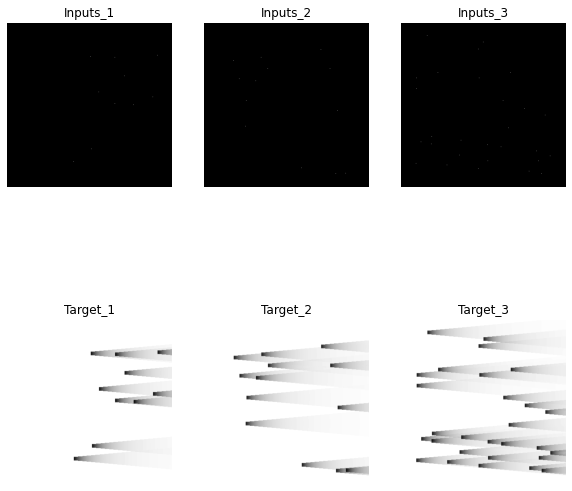

In [9]:

fig=plt.figure(figsize=(10,10))
for i in range(3):
    ax = fig.add_subplot(2, 3, i + 1)

    ax.imshow(dataset.__getitem__(i)[0].squeeze(0), cmap='gray')
    ax.set_title('Inputs_{}'.format(i+1))
    ax.axis("off")
    ax =fig.add_subplot(2, 3, i + 1 + 3)
    ax.imshow(dataset.__getitem__(i)[1].squeeze(0),cmap='gray')
    ax.set_title('Target_{}'.format(i+1))
    ax.axis("off")

plt.show()

In [10]:
# Split the dataset

ntest = int(0.1 * len(dataset))
nvalid=int(0.1*(len(dataset)))
ntrain=(len(dataset) - ntest-nvalid)
train_data,valid_data,test_data = random_split(dataset, lengths=[ntrain, nvalid,ntest])
ntest=len(test_data)
nvalid=len(test_data)
ntrain=len(train_data)
print('Number of train data:{}\nNumber of valid data:{}\nNumber of test data:{}'.format(ntrain,nvalid,ntest ))


Number of train data:206
Number of valid data:25
Number of test data:25


## Train

In [11]:
def evaluate(model,valid_set, batch_size):


    
    val_loss=0
    
    device='cuda'

    

        
    for step,(inputs, target,u_inf,power,coor_loc) in enumerate(valid_set):
            #images, labels = get_torch_vars(xs, ys, args.gpu)

            #############################################
            #To Enable GPU Usage

            #############################################
        inputs  = inputs.to(device, dtype=torch.float)
            #targets= targets.to(device, dtype=torch.float)
        target= target.to(device, dtype=torch.float)

        output = model(inputs)
        loss=F.mse_loss(output, target, reduction='sum')

        val_loss+=loss.item()
        
            
    
    
    return val_loss

In [22]:

def train(args,model):
    train_set=torch.utils.data.DataLoader(train_data, args.batch_size, pin_memory=True, num_workers=0)
    valid_set=torch.utils.data.DataLoader(valid_data, args.test_batch_size, pin_memory=True, num_workers=0)
    optimizer = torch.optim.Adam(model.parameters(), lr=args.learning_rate,
                       weight_decay=args.weight_decay)
    scheduler=ReduceLROnPlateau(optimizer,mode='min',threshold_mode='rel', cooldown=0, min_lr=0, eps=1e-8)
    n_out_pixels_train = args.ntrain * train_data[0][1].numel()
    n_out_pixels_valid = args.nvalid * valid_data[0][1].numel()
    train_losses=[]
    RMSE_train=[]
    RMSE_valid=[]
    Epochs=[]
    train_loss=0
    valid_losses=[]
    device='cuda'
    for epoch in range(args.epochs):
        #print(epoch)
        # Train the Model
        model.train()  # Change model to 'train' mod
        train_loss=0
        for step,(inputs, target,u_inf,power,coor_loc) in enumerate(train_set):
            
            inputs  = inputs.to(device, dtype=torch.float)
            targets= target.to(device, dtype=torch.float)
            #wakes= wake.to(device, dtype=torch.float)
            model.zero_grad()
            outputs=model(inputs)

          
                    
                
            loss=F.mse_loss(outputs, targets, reduction='sum')
            loss.backward()
            optimizer.step()
            train_loss+=loss.item()

 
    
        train_losses.append(train_loss)   
        rmse = np.sqrt(train_loss / n_out_pixels_train)
        RMSE_train.append(rmse)
        scheduler.step(rmse)
        Epochs.append(epoch+1)
        model.eval()
        val_loss=evaluate(model,valid_set, args.test_batch_size)
        rmse_val = np.sqrt(val_loss / n_out_pixels_valid)
        RMSE_valid.append(rmse_val)
        #print(("Epoch {}: , Train RMSE: {},Validation RMSE: {}").format(
                  # epoch ,
                  # rmse,rmse_val))
        valid_losses.append(val_loss)
        #print(("Epoch {}: , Train loss: {},Validation loss: {}").format(
                   #epoch ,
                   #train_loss,val_loss))
        
            
       # model_path = save_dir + "/_epoch_" + str(epoch)
        
            

        #torch.save(gen.state_dict(), model_path)
        
        #print(""epoch, loss.cpu().detach())


    
    return model


In [23]:
class AttrDict(dict):
    def __init__(self, *args, **kwargs):
        super(AttrDict, self).__init__(*args, **kwargs)
        self.__dict__ = self

In [24]:
#Main training loop for CNN
args = AttrDict()
args_dict = {
    "gpu": True,
    "valid": False,
   

    
   

    "visualize": False,
    "downsize_input": False,
    "batch_size":32,
    "test_batch_size":8,
    "learning_rate":3e-3,
    "weight_decay":0.005,
    "epochs":200,
    "ntrain":ntrain,
    "ntest":ntest,
    "nvalid":nvalid,
    "in_channel":1,
    "out_channel":1,
    "init_features":4,
    "bn_size":8
    
}





In [25]:
def evalu_fun(train_data,valid_data,test_data,k,growth_rate,x,x1,x2,x3,x4):
    args.update(args_dict)
    device = 'cuda'
    if k==1:
        k_size=3
    elif k==2:
        k_size=5
    elif k==3:
        k_size=7
    elif k==4:
        k_size=9

        
    if x==1:
        model=Dense_C8_skip_more_one(args.in_channel,k_size,x1,x2,x3,x4, args.out_channel, args.init_features,growth_rate,args.bn_size,bottleneck=False,drop_out=0)
    elif x==2:
        model=Dense_C8_skip_more(args.in_channel,k_size,x1,x2,x3,x4, args.out_channel, args.init_features,growth_rate,args.bn_size,bottleneck=False,drop_out=0)
    elif x==3:
        model=Dense_C8_skip(args.in_channel,k_size,x1,x2,x3,x4, args.out_channel, args.init_features,growth_rate,args.bn_size,bottleneck=False,drop_out=0)
    #print('11111')
    
    model=model.to(device)
    summary(model, (1, 400, 400))
    total_params = sum(p.numel() for p in model.parameters())
    print (type(model).__name__)
    print('kerne_size=',k_size)
    print('growth_rate=',growth_rate)
    print('x1=',x1)
    print('x2=',x2)
    print('x3=',x3)
    print('x4=',x4)
    CNN=train(args,model)
    n_out_pixels_test = args.ntest * test_data[0][1].numel()
    test_set=torch.utils.data.DataLoader(test_data, args.test_batch_size, pin_memory=True, num_workers=0)
    test_loss=evaluate(CNN,test_set, args.test_batch_size)
    rmse_test = np.sqrt(test_loss / n_out_pixels_test)
    return rmse_test,total_params
    

## Pymo Optimization

In [26]:
#epochs=100
evalualte = lambda x: evalu_fun(train_data,valid_data,test_data,k=x[0],growth_rate=x[1],x=x[2],x1=x[3],x2=x[4],x3=x[5],x4=x[6])

objs=evalualte
#apply constrains
constr_ieq = [
    lambda x: 1*(x[0]-5), 
    lambda x: 1*(x[1]-13),
    lambda x: 1*(x[2]-4),
    lambda x: 1*(x[3]-1),
    lambda x: 1*(x[4]-1),
    lambda x: 1*(x[5]-1),
    lambda x: 1*(x[6]-1)
]

constr_eq = []

In [27]:
from pymoo.problems.functional import FunctionalProblem
from pymoo.problems.constr_as_penalty import ConstraintsAsPenalty

problem = FunctionalProblem(7,
                            objs,
                            xl=np.array([1,1,1,0,0,0,0]),
                            xu=np.array([4,12,3,1,1,1,1]),
                            constr_ieq=constr_ieq,
                            constr_eq=constr_eq
                            )

problem = ConstraintsAsPenalty(problem, penalty=1e10)

In [28]:
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.factory import get_sampling, get_crossover, get_mutation
#optimization(NSGA2)
algorithm = NSGA2(
    pop_size=40,
    n_offsprings=20,
    sampling=get_sampling("int_random"),
    crossover=get_crossover("int_sbx", prob=0.9, eta=15),
    mutation=get_mutation("int_pm", eta=20),
    eliminate_duplicates=True
)

In [29]:
from pymoo.factory import get_termination

termination = get_termination("n_gen", 10)
from pymoo.optimize import minimize

res = minimize(problem,
               algorithm,
               termination,
               seed=1,
               save_history=True,
               verbose=True)
res.X

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 4, 200, 200]             144
       BatchNorm2d-2          [-1, 4, 200, 200]               8
              ReLU-3          [-1, 4, 200, 200]               0
            Conv2d-4          [-1, 9, 200, 200]             900
        conv_layer-5         [-1, 13, 200, 200]               0
       BatchNorm2d-6         [-1, 13, 200, 200]              26
              ReLU-7         [-1, 13, 200, 200]               0
            Conv2d-8          [-1, 9, 200, 200]           2,925
        conv_layer-9         [-1, 22, 200, 200]               0
      Dense_block-10         [-1, 22, 200, 200]               0
      BatchNorm2d-11         [-1, 22, 200, 200]              44
             ReLU-12         [-1, 22, 200, 200]               0
           Conv2d-13         [-1, 11, 200, 200]             242
      BatchNorm2d-14         [-1, 11, 2

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 4, 200, 200]             144
       BatchNorm2d-2          [-1, 4, 200, 200]               8
              ReLU-3          [-1, 4, 200, 200]               0
            Conv2d-4          [-1, 5, 200, 200]             500
        conv_layer-5          [-1, 9, 200, 200]               0
       BatchNorm2d-6          [-1, 9, 200, 200]              18
              ReLU-7          [-1, 9, 200, 200]               0
            Conv2d-8          [-1, 5, 200, 200]           1,125
        conv_layer-9         [-1, 14, 200, 200]               0
      Dense_block-10         [-1, 14, 200, 200]               0
      BatchNorm2d-11         [-1, 14, 200, 200]              28
             ReLU-12         [-1, 14, 200, 200]               0
           Conv2d-13          [-1, 7, 200, 200]              98
      BatchNorm2d-14          [-1, 7, 2

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 4, 200, 200]             144
       BatchNorm2d-2          [-1, 4, 200, 200]               8
              ReLU-3          [-1, 4, 200, 200]               0
            Conv2d-4          [-1, 9, 200, 200]             324
        conv_layer-5         [-1, 13, 200, 200]               0
       BatchNorm2d-6         [-1, 13, 200, 200]              26
              ReLU-7         [-1, 13, 200, 200]               0
            Conv2d-8          [-1, 9, 200, 200]           1,053
        conv_layer-9         [-1, 22, 200, 200]               0
      Dense_block-10         [-1, 22, 200, 200]               0
      BatchNorm2d-11         [-1, 22, 200, 200]              44
             ReLU-12         [-1, 22, 200, 200]               0
           Conv2d-13         [-1, 11, 200, 200]             242
      BatchNorm2d-14         [-1, 11, 2

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 4, 200, 200]             144
       BatchNorm2d-2          [-1, 4, 200, 200]               8
              ReLU-3          [-1, 4, 200, 200]               0
            Conv2d-4          [-1, 4, 200, 200]           1,296
        conv_layer-5          [-1, 8, 200, 200]               0
       BatchNorm2d-6          [-1, 8, 200, 200]              16
              ReLU-7          [-1, 8, 200, 200]               0
            Conv2d-8          [-1, 4, 200, 200]           2,592
        conv_layer-9         [-1, 12, 200, 200]               0
      Dense_block-10         [-1, 12, 200, 200]               0
      BatchNorm2d-11         [-1, 12, 200, 200]              24
             ReLU-12         [-1, 12, 200, 200]               0
           Conv2d-13          [-1, 6, 200, 200]              72
      BatchNorm2d-14          [-1, 6, 2

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 4, 200, 200]             144
       BatchNorm2d-2          [-1, 4, 200, 200]               8
              ReLU-3          [-1, 4, 200, 200]               0
            Conv2d-4          [-1, 9, 200, 200]             900
        conv_layer-5         [-1, 13, 200, 200]               0
       BatchNorm2d-6         [-1, 13, 200, 200]              26
              ReLU-7         [-1, 13, 200, 200]               0
            Conv2d-8          [-1, 9, 200, 200]           2,925
        conv_layer-9         [-1, 22, 200, 200]               0
      Dense_block-10         [-1, 22, 200, 200]               0
      BatchNorm2d-11         [-1, 22, 200, 200]              44
             ReLU-12         [-1, 22, 200, 200]               0
           Conv2d-13         [-1, 11, 200, 200]             242
      BatchNorm2d-14         [-1, 11, 2

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 4, 200, 200]             144
       BatchNorm2d-2          [-1, 4, 200, 200]               8
              ReLU-3          [-1, 4, 200, 200]               0
            Conv2d-4          [-1, 1, 200, 200]              36
        conv_layer-5          [-1, 5, 200, 200]               0
       BatchNorm2d-6          [-1, 5, 200, 200]              10
              ReLU-7          [-1, 5, 200, 200]               0
            Conv2d-8          [-1, 1, 200, 200]              45
        conv_layer-9          [-1, 6, 200, 200]               0
      Dense_block-10          [-1, 6, 200, 200]               0
      BatchNorm2d-11          [-1, 6, 200, 200]              12
             ReLU-12          [-1, 6, 200, 200]               0
           Conv2d-13          [-1, 3, 200, 200]              18
      BatchNorm2d-14          [-1, 3, 2

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 4, 200, 200]             144
       BatchNorm2d-2          [-1, 4, 200, 200]               8
              ReLU-3          [-1, 4, 200, 200]               0
            Conv2d-4          [-1, 1, 200, 200]             100
        conv_layer-5          [-1, 5, 200, 200]               0
       BatchNorm2d-6          [-1, 5, 200, 200]              10
              ReLU-7          [-1, 5, 200, 200]               0
            Conv2d-8          [-1, 1, 200, 200]             125
        conv_layer-9          [-1, 6, 200, 200]               0
      Dense_block-10          [-1, 6, 200, 200]               0
      BatchNorm2d-11          [-1, 6, 200, 200]              12
             ReLU-12          [-1, 6, 200, 200]               0
           Conv2d-13          [-1, 3, 200, 200]              18
      BatchNorm2d-14          [-1, 3, 2

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 4, 200, 200]             144
       BatchNorm2d-2          [-1, 4, 200, 200]               8
              ReLU-3          [-1, 4, 200, 200]               0
            Conv2d-4          [-1, 2, 200, 200]             648
        conv_layer-5          [-1, 6, 200, 200]               0
       BatchNorm2d-6          [-1, 6, 200, 200]              12
              ReLU-7          [-1, 6, 200, 200]               0
            Conv2d-8          [-1, 2, 200, 200]             972
        conv_layer-9          [-1, 8, 200, 200]               0
      Dense_block-10          [-1, 8, 200, 200]               0
      BatchNorm2d-11          [-1, 8, 200, 200]              16
             ReLU-12          [-1, 8, 200, 200]               0
           Conv2d-13          [-1, 4, 200, 200]              32
      BatchNorm2d-14          [-1, 4, 2

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 4, 200, 200]             144
       BatchNorm2d-2          [-1, 4, 200, 200]               8
              ReLU-3          [-1, 4, 200, 200]               0
            Conv2d-4         [-1, 10, 200, 200]           1,000
        conv_layer-5         [-1, 14, 200, 200]               0
       BatchNorm2d-6         [-1, 14, 200, 200]              28
              ReLU-7         [-1, 14, 200, 200]               0
            Conv2d-8         [-1, 10, 200, 200]           3,500
        conv_layer-9         [-1, 24, 200, 200]               0
      Dense_block-10         [-1, 24, 200, 200]               0
      BatchNorm2d-11         [-1, 24, 200, 200]              48
             ReLU-12         [-1, 24, 200, 200]               0
           Conv2d-13         [-1, 12, 200, 200]             288
      BatchNorm2d-14         [-1, 12, 2

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 4, 200, 200]             144
       BatchNorm2d-2          [-1, 4, 200, 200]               8
              ReLU-3          [-1, 4, 200, 200]               0
            Conv2d-4          [-1, 6, 200, 200]           1,944
        conv_layer-5         [-1, 10, 200, 200]               0
       BatchNorm2d-6         [-1, 10, 200, 200]              20
              ReLU-7         [-1, 10, 200, 200]               0
            Conv2d-8          [-1, 6, 200, 200]           4,860
        conv_layer-9         [-1, 16, 200, 200]               0
      Dense_block-10         [-1, 16, 200, 200]               0
      BatchNorm2d-11         [-1, 16, 200, 200]              32
             ReLU-12         [-1, 16, 200, 200]               0
           Conv2d-13          [-1, 8, 200, 200]             128
      BatchNorm2d-14          [-1, 8, 2

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 4, 200, 200]             144
       BatchNorm2d-2          [-1, 4, 200, 200]               8
              ReLU-3          [-1, 4, 200, 200]               0
            Conv2d-4          [-1, 8, 200, 200]             288
        conv_layer-5         [-1, 12, 200, 200]               0
       BatchNorm2d-6         [-1, 12, 200, 200]              24
              ReLU-7         [-1, 12, 200, 200]               0
            Conv2d-8          [-1, 8, 200, 200]             864
        conv_layer-9         [-1, 20, 200, 200]               0
      Dense_block-10         [-1, 20, 200, 200]               0
      BatchNorm2d-11         [-1, 20, 200, 200]              40
             ReLU-12         [-1, 20, 200, 200]               0
           Conv2d-13         [-1, 10, 200, 200]             200
      BatchNorm2d-14         [-1, 10, 2

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 4, 200, 200]             144
       BatchNorm2d-2          [-1, 4, 200, 200]               8
              ReLU-3          [-1, 4, 200, 200]               0
            Conv2d-4          [-1, 1, 200, 200]             196
        conv_layer-5          [-1, 5, 200, 200]               0
       BatchNorm2d-6          [-1, 5, 200, 200]              10
              ReLU-7          [-1, 5, 200, 200]               0
            Conv2d-8          [-1, 1, 200, 200]             245
        conv_layer-9          [-1, 6, 200, 200]               0
      Dense_block-10          [-1, 6, 200, 200]               0
      BatchNorm2d-11          [-1, 6, 200, 200]              12
             ReLU-12          [-1, 6, 200, 200]               0
           Conv2d-13          [-1, 3, 200, 200]              18
      BatchNorm2d-14          [-1, 3, 2

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 4, 200, 200]             144
       BatchNorm2d-2          [-1, 4, 200, 200]               8
              ReLU-3          [-1, 4, 200, 200]               0
            Conv2d-4          [-1, 1, 200, 200]              36
        conv_layer-5          [-1, 5, 200, 200]               0
       BatchNorm2d-6          [-1, 5, 200, 200]              10
              ReLU-7          [-1, 5, 200, 200]               0
            Conv2d-8          [-1, 1, 200, 200]              45
        conv_layer-9          [-1, 6, 200, 200]               0
      Dense_block-10          [-1, 6, 200, 200]               0
      BatchNorm2d-11          [-1, 6, 200, 200]              12
             ReLU-12          [-1, 6, 200, 200]               0
           Conv2d-13          [-1, 3, 200, 200]              18
      BatchNorm2d-14          [-1, 3, 2

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 4, 200, 200]             144
       BatchNorm2d-2          [-1, 4, 200, 200]               8
              ReLU-3          [-1, 4, 200, 200]               0
            Conv2d-4         [-1, 11, 200, 200]           2,156
        conv_layer-5         [-1, 15, 200, 200]               0
       BatchNorm2d-6         [-1, 15, 200, 200]              30
              ReLU-7         [-1, 15, 200, 200]               0
            Conv2d-8         [-1, 11, 200, 200]           8,085
        conv_layer-9         [-1, 26, 200, 200]               0
      Dense_block-10         [-1, 26, 200, 200]               0
      BatchNorm2d-11         [-1, 26, 200, 200]              52
             ReLU-12         [-1, 26, 200, 200]               0
           Conv2d-13         [-1, 13, 200, 200]             338
      BatchNorm2d-14         [-1, 13, 2

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 4, 200, 200]             144
       BatchNorm2d-2          [-1, 4, 200, 200]               8
              ReLU-3          [-1, 4, 200, 200]               0
            Conv2d-4         [-1, 10, 200, 200]             360
        conv_layer-5         [-1, 14, 200, 200]               0
       BatchNorm2d-6         [-1, 14, 200, 200]              28
              ReLU-7         [-1, 14, 200, 200]               0
            Conv2d-8         [-1, 10, 200, 200]           1,260
        conv_layer-9         [-1, 24, 200, 200]               0
      Dense_block-10         [-1, 24, 200, 200]               0
      BatchNorm2d-11         [-1, 24, 200, 200]              48
             ReLU-12         [-1, 24, 200, 200]               0
           Conv2d-13         [-1, 12, 200, 200]             288
      BatchNorm2d-14         [-1, 12, 2

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 4, 200, 200]             144
       BatchNorm2d-2          [-1, 4, 200, 200]               8
              ReLU-3          [-1, 4, 200, 200]               0
            Conv2d-4          [-1, 2, 200, 200]             392
        conv_layer-5          [-1, 6, 200, 200]               0
       BatchNorm2d-6          [-1, 6, 200, 200]              12
              ReLU-7          [-1, 6, 200, 200]               0
            Conv2d-8          [-1, 2, 200, 200]             588
        conv_layer-9          [-1, 8, 200, 200]               0
      Dense_block-10          [-1, 8, 200, 200]               0
      BatchNorm2d-11          [-1, 8, 200, 200]              16
             ReLU-12          [-1, 8, 200, 200]               0
           Conv2d-13          [-1, 4, 200, 200]              32
      BatchNorm2d-14          [-1, 4, 2

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 4, 200, 200]             144
       BatchNorm2d-2          [-1, 4, 200, 200]               8
              ReLU-3          [-1, 4, 200, 200]               0
            Conv2d-4          [-1, 7, 200, 200]           1,372
        conv_layer-5         [-1, 11, 200, 200]               0
       BatchNorm2d-6         [-1, 11, 200, 200]              22
              ReLU-7         [-1, 11, 200, 200]               0
            Conv2d-8          [-1, 7, 200, 200]           3,773
        conv_layer-9         [-1, 18, 200, 200]               0
      Dense_block-10         [-1, 18, 200, 200]               0
      BatchNorm2d-11         [-1, 18, 200, 200]              36
             ReLU-12         [-1, 18, 200, 200]               0
           Conv2d-13          [-1, 9, 200, 200]             162
      BatchNorm2d-14          [-1, 9, 2

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 4, 200, 200]             144
       BatchNorm2d-2          [-1, 4, 200, 200]               8
              ReLU-3          [-1, 4, 200, 200]               0
            Conv2d-4          [-1, 9, 200, 200]             900
        conv_layer-5         [-1, 13, 200, 200]               0
       BatchNorm2d-6         [-1, 13, 200, 200]              26
              ReLU-7         [-1, 13, 200, 200]               0
            Conv2d-8          [-1, 9, 200, 200]           2,925
        conv_layer-9         [-1, 22, 200, 200]               0
      Dense_block-10         [-1, 22, 200, 200]               0
      BatchNorm2d-11         [-1, 22, 200, 200]              44
             ReLU-12         [-1, 22, 200, 200]               0
           Conv2d-13         [-1, 11, 200, 200]             242
      BatchNorm2d-14         [-1, 11, 2

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 4, 200, 200]             144
       BatchNorm2d-2          [-1, 4, 200, 200]               8
              ReLU-3          [-1, 4, 200, 200]               0
            Conv2d-4          [-1, 8, 200, 200]             800
        conv_layer-5         [-1, 12, 200, 200]               0
       BatchNorm2d-6         [-1, 12, 200, 200]              24
              ReLU-7         [-1, 12, 200, 200]               0
            Conv2d-8          [-1, 8, 200, 200]           2,400
        conv_layer-9         [-1, 20, 200, 200]               0
      Dense_block-10         [-1, 20, 200, 200]               0
      BatchNorm2d-11         [-1, 20, 200, 200]              40
             ReLU-12         [-1, 20, 200, 200]               0
           Conv2d-13         [-1, 10, 200, 200]             200
      BatchNorm2d-14         [-1, 10, 2

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 4, 200, 200]             144
       BatchNorm2d-2          [-1, 4, 200, 200]               8
              ReLU-3          [-1, 4, 200, 200]               0
            Conv2d-4          [-1, 9, 200, 200]           1,764
        conv_layer-5         [-1, 13, 200, 200]               0
       BatchNorm2d-6         [-1, 13, 200, 200]              26
              ReLU-7         [-1, 13, 200, 200]               0
            Conv2d-8          [-1, 9, 200, 200]           5,733
        conv_layer-9         [-1, 22, 200, 200]               0
      Dense_block-10         [-1, 22, 200, 200]               0
      BatchNorm2d-11         [-1, 22, 200, 200]              44
             ReLU-12         [-1, 22, 200, 200]               0
           Conv2d-13         [-1, 11, 200, 200]             242
      BatchNorm2d-14         [-1, 11, 2

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 4, 200, 200]             144
       BatchNorm2d-2          [-1, 4, 200, 200]               8
              ReLU-3          [-1, 4, 200, 200]               0
            Conv2d-4          [-1, 1, 200, 200]             324
        conv_layer-5          [-1, 5, 200, 200]               0
       BatchNorm2d-6          [-1, 5, 200, 200]              10
              ReLU-7          [-1, 5, 200, 200]               0
            Conv2d-8          [-1, 1, 200, 200]             405
        conv_layer-9          [-1, 6, 200, 200]               0
      Dense_block-10          [-1, 6, 200, 200]               0
      BatchNorm2d-11          [-1, 6, 200, 200]              12
             ReLU-12          [-1, 6, 200, 200]               0
           Conv2d-13          [-1, 3, 200, 200]              18
      BatchNorm2d-14          [-1, 3, 2

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 4, 200, 200]             144
       BatchNorm2d-2          [-1, 4, 200, 200]               8
              ReLU-3          [-1, 4, 200, 200]               0
            Conv2d-4          [-1, 4, 200, 200]           1,296
        conv_layer-5          [-1, 8, 200, 200]               0
       BatchNorm2d-6          [-1, 8, 200, 200]              16
              ReLU-7          [-1, 8, 200, 200]               0
            Conv2d-8          [-1, 4, 200, 200]           2,592
        conv_layer-9         [-1, 12, 200, 200]               0
      Dense_block-10         [-1, 12, 200, 200]               0
      BatchNorm2d-11         [-1, 12, 200, 200]              24
             ReLU-12         [-1, 12, 200, 200]               0
           Conv2d-13          [-1, 6, 200, 200]              72
      BatchNorm2d-14          [-1, 6, 2

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 4, 200, 200]             144
       BatchNorm2d-2          [-1, 4, 200, 200]               8
              ReLU-3          [-1, 4, 200, 200]               0
            Conv2d-4          [-1, 3, 200, 200]             108
        conv_layer-5          [-1, 7, 200, 200]               0
       BatchNorm2d-6          [-1, 7, 200, 200]              14
              ReLU-7          [-1, 7, 200, 200]               0
            Conv2d-8          [-1, 3, 200, 200]             189
        conv_layer-9         [-1, 10, 200, 200]               0
      Dense_block-10         [-1, 10, 200, 200]               0
      BatchNorm2d-11         [-1, 10, 200, 200]              20
             ReLU-12         [-1, 10, 200, 200]               0
           Conv2d-13          [-1, 5, 200, 200]              50
      BatchNorm2d-14          [-1, 5, 2

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 4, 200, 200]             144
       BatchNorm2d-2          [-1, 4, 200, 200]               8
              ReLU-3          [-1, 4, 200, 200]               0
            Conv2d-4          [-1, 5, 200, 200]             980
        conv_layer-5          [-1, 9, 200, 200]               0
       BatchNorm2d-6          [-1, 9, 200, 200]              18
              ReLU-7          [-1, 9, 200, 200]               0
            Conv2d-8          [-1, 5, 200, 200]           2,205
        conv_layer-9         [-1, 14, 200, 200]               0
      Dense_block-10         [-1, 14, 200, 200]               0
      BatchNorm2d-11         [-1, 14, 200, 200]              28
             ReLU-12         [-1, 14, 200, 200]               0
           Conv2d-13          [-1, 7, 200, 200]              98
      BatchNorm2d-14          [-1, 7, 2

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 4, 200, 200]             144
       BatchNorm2d-2          [-1, 4, 200, 200]               8
              ReLU-3          [-1, 4, 200, 200]               0
            Conv2d-4         [-1, 12, 200, 200]           1,200
        conv_layer-5         [-1, 16, 200, 200]               0
       BatchNorm2d-6         [-1, 16, 200, 200]              32
              ReLU-7         [-1, 16, 200, 200]               0
            Conv2d-8         [-1, 12, 200, 200]           4,800
        conv_layer-9         [-1, 28, 200, 200]               0
      Dense_block-10         [-1, 28, 200, 200]               0
      BatchNorm2d-11         [-1, 28, 200, 200]              56
             ReLU-12         [-1, 28, 200, 200]               0
           Conv2d-13         [-1, 14, 200, 200]             392
      BatchNorm2d-14         [-1, 14, 2

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 4, 200, 200]             144
       BatchNorm2d-2          [-1, 4, 200, 200]               8
              ReLU-3          [-1, 4, 200, 200]               0
            Conv2d-4         [-1, 10, 200, 200]           3,240
        conv_layer-5         [-1, 14, 200, 200]               0
       BatchNorm2d-6         [-1, 14, 200, 200]              28
              ReLU-7         [-1, 14, 200, 200]               0
            Conv2d-8         [-1, 10, 200, 200]          11,340
        conv_layer-9         [-1, 24, 200, 200]               0
      Dense_block-10         [-1, 24, 200, 200]               0
      BatchNorm2d-11         [-1, 24, 200, 200]              48
             ReLU-12         [-1, 24, 200, 200]               0
           Conv2d-13         [-1, 12, 200, 200]             288
      BatchNorm2d-14         [-1, 12, 2

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 4, 200, 200]             144
       BatchNorm2d-2          [-1, 4, 200, 200]               8
              ReLU-3          [-1, 4, 200, 200]               0
            Conv2d-4         [-1, 12, 200, 200]           1,200
        conv_layer-5         [-1, 16, 200, 200]               0
       BatchNorm2d-6         [-1, 16, 200, 200]              32
              ReLU-7         [-1, 16, 200, 200]               0
            Conv2d-8         [-1, 12, 200, 200]           4,800
        conv_layer-9         [-1, 28, 200, 200]               0
      Dense_block-10         [-1, 28, 200, 200]               0
      BatchNorm2d-11         [-1, 28, 200, 200]              56
             ReLU-12         [-1, 28, 200, 200]               0
           Conv2d-13         [-1, 14, 200, 200]             392
      BatchNorm2d-14         [-1, 14, 2

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 4, 200, 200]             144
       BatchNorm2d-2          [-1, 4, 200, 200]               8
              ReLU-3          [-1, 4, 200, 200]               0
            Conv2d-4         [-1, 10, 200, 200]           1,960
        conv_layer-5         [-1, 14, 200, 200]               0
       BatchNorm2d-6         [-1, 14, 200, 200]              28
              ReLU-7         [-1, 14, 200, 200]               0
            Conv2d-8         [-1, 10, 200, 200]           6,860
        conv_layer-9         [-1, 24, 200, 200]               0
      Dense_block-10         [-1, 24, 200, 200]               0
      BatchNorm2d-11         [-1, 24, 200, 200]              48
             ReLU-12         [-1, 24, 200, 200]               0
           Conv2d-13         [-1, 12, 200, 200]             288
      BatchNorm2d-14         [-1, 12, 2

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 4, 200, 200]             144
       BatchNorm2d-2          [-1, 4, 200, 200]               8
              ReLU-3          [-1, 4, 200, 200]               0
            Conv2d-4         [-1, 10, 200, 200]           1,000
        conv_layer-5         [-1, 14, 200, 200]               0
       BatchNorm2d-6         [-1, 14, 200, 200]              28
              ReLU-7         [-1, 14, 200, 200]               0
            Conv2d-8         [-1, 10, 200, 200]           3,500
        conv_layer-9         [-1, 24, 200, 200]               0
      Dense_block-10         [-1, 24, 200, 200]               0
      BatchNorm2d-11         [-1, 24, 200, 200]              48
             ReLU-12         [-1, 24, 200, 200]               0
           Conv2d-13         [-1, 12, 200, 200]             288
      BatchNorm2d-14         [-1, 12, 2

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 4, 200, 200]             144
       BatchNorm2d-2          [-1, 4, 200, 200]               8
              ReLU-3          [-1, 4, 200, 200]               0
            Conv2d-4          [-1, 1, 200, 200]             196
        conv_layer-5          [-1, 5, 200, 200]               0
       BatchNorm2d-6          [-1, 5, 200, 200]              10
              ReLU-7          [-1, 5, 200, 200]               0
            Conv2d-8          [-1, 1, 200, 200]             245
        conv_layer-9          [-1, 6, 200, 200]               0
      Dense_block-10          [-1, 6, 200, 200]               0
      BatchNorm2d-11          [-1, 6, 200, 200]              12
             ReLU-12          [-1, 6, 200, 200]               0
           Conv2d-13          [-1, 3, 200, 200]              18
      BatchNorm2d-14          [-1, 3, 2

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 4, 200, 200]             144
       BatchNorm2d-2          [-1, 4, 200, 200]               8
              ReLU-3          [-1, 4, 200, 200]               0
            Conv2d-4         [-1, 10, 200, 200]           1,960
        conv_layer-5         [-1, 14, 200, 200]               0
       BatchNorm2d-6         [-1, 14, 200, 200]              28
              ReLU-7         [-1, 14, 200, 200]               0
            Conv2d-8         [-1, 10, 200, 200]           6,860
        conv_layer-9         [-1, 24, 200, 200]               0
      Dense_block-10         [-1, 24, 200, 200]               0
      BatchNorm2d-11         [-1, 24, 200, 200]              48
             ReLU-12         [-1, 24, 200, 200]               0
           Conv2d-13         [-1, 12, 200, 200]             288
      BatchNorm2d-14         [-1, 12, 2

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 4, 200, 200]             144
       BatchNorm2d-2          [-1, 4, 200, 200]               8
              ReLU-3          [-1, 4, 200, 200]               0
            Conv2d-4         [-1, 12, 200, 200]           1,200
        conv_layer-5         [-1, 16, 200, 200]               0
       BatchNorm2d-6         [-1, 16, 200, 200]              32
              ReLU-7         [-1, 16, 200, 200]               0
            Conv2d-8         [-1, 12, 200, 200]           4,800
        conv_layer-9         [-1, 28, 200, 200]               0
      Dense_block-10         [-1, 28, 200, 200]               0
      BatchNorm2d-11         [-1, 28, 200, 200]              56
             ReLU-12         [-1, 28, 200, 200]               0
           Conv2d-13         [-1, 14, 200, 200]             392
      BatchNorm2d-14         [-1, 14, 2

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 4, 200, 200]             144
       BatchNorm2d-2          [-1, 4, 200, 200]               8
              ReLU-3          [-1, 4, 200, 200]               0
            Conv2d-4         [-1, 10, 200, 200]           1,000
        conv_layer-5         [-1, 14, 200, 200]               0
       BatchNorm2d-6         [-1, 14, 200, 200]              28
              ReLU-7         [-1, 14, 200, 200]               0
            Conv2d-8         [-1, 10, 200, 200]           3,500
        conv_layer-9         [-1, 24, 200, 200]               0
      Dense_block-10         [-1, 24, 200, 200]               0
      BatchNorm2d-11         [-1, 24, 200, 200]              48
             ReLU-12         [-1, 24, 200, 200]               0
           Conv2d-13         [-1, 12, 200, 200]             288
      BatchNorm2d-14         [-1, 12, 2

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 4, 200, 200]             144
       BatchNorm2d-2          [-1, 4, 200, 200]               8
              ReLU-3          [-1, 4, 200, 200]               0
            Conv2d-4         [-1, 12, 200, 200]           2,352
        conv_layer-5         [-1, 16, 200, 200]               0
       BatchNorm2d-6         [-1, 16, 200, 200]              32
              ReLU-7         [-1, 16, 200, 200]               0
            Conv2d-8         [-1, 12, 200, 200]           9,408
        conv_layer-9         [-1, 28, 200, 200]               0
      Dense_block-10         [-1, 28, 200, 200]               0
      BatchNorm2d-11         [-1, 28, 200, 200]              56
             ReLU-12         [-1, 28, 200, 200]               0
           Conv2d-13         [-1, 14, 200, 200]             392
      BatchNorm2d-14         [-1, 14, 2

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 4, 200, 200]             144
       BatchNorm2d-2          [-1, 4, 200, 200]               8
              ReLU-3          [-1, 4, 200, 200]               0
            Conv2d-4          [-1, 2, 200, 200]             200
        conv_layer-5          [-1, 6, 200, 200]               0
       BatchNorm2d-6          [-1, 6, 200, 200]              12
              ReLU-7          [-1, 6, 200, 200]               0
            Conv2d-8          [-1, 2, 200, 200]             300
        conv_layer-9          [-1, 8, 200, 200]               0
      Dense_block-10          [-1, 8, 200, 200]               0
      BatchNorm2d-11          [-1, 8, 200, 200]              16
             ReLU-12          [-1, 8, 200, 200]               0
           Conv2d-13          [-1, 4, 200, 200]              32
      BatchNorm2d-14          [-1, 4, 2

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 4, 200, 200]             144
       BatchNorm2d-2          [-1, 4, 200, 200]               8
              ReLU-3          [-1, 4, 200, 200]               0
            Conv2d-4          [-1, 6, 200, 200]             600
        conv_layer-5         [-1, 10, 200, 200]               0
       BatchNorm2d-6         [-1, 10, 200, 200]              20
              ReLU-7         [-1, 10, 200, 200]               0
            Conv2d-8          [-1, 6, 200, 200]           1,500
        conv_layer-9         [-1, 16, 200, 200]               0
      Dense_block-10         [-1, 16, 200, 200]               0
      BatchNorm2d-11         [-1, 16, 200, 200]              32
             ReLU-12         [-1, 16, 200, 200]               0
           Conv2d-13          [-1, 8, 200, 200]             128
      BatchNorm2d-14          [-1, 8, 2

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 4, 200, 200]             144
       BatchNorm2d-2          [-1, 4, 200, 200]               8
              ReLU-3          [-1, 4, 200, 200]               0
            Conv2d-4         [-1, 11, 200, 200]           2,156
        conv_layer-5         [-1, 15, 200, 200]               0
       BatchNorm2d-6         [-1, 15, 200, 200]              30
              ReLU-7         [-1, 15, 200, 200]               0
            Conv2d-8         [-1, 11, 200, 200]           8,085
        conv_layer-9         [-1, 26, 200, 200]               0
      Dense_block-10         [-1, 26, 200, 200]               0
      BatchNorm2d-11         [-1, 26, 200, 200]              52
             ReLU-12         [-1, 26, 200, 200]               0
           Conv2d-13         [-1, 13, 200, 200]             338
      BatchNorm2d-14         [-1, 13, 2

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 4, 200, 200]             144
       BatchNorm2d-2          [-1, 4, 200, 200]               8
              ReLU-3          [-1, 4, 200, 200]               0
            Conv2d-4          [-1, 9, 200, 200]           1,764
        conv_layer-5         [-1, 13, 200, 200]               0
       BatchNorm2d-6         [-1, 13, 200, 200]              26
              ReLU-7         [-1, 13, 200, 200]               0
            Conv2d-8          [-1, 9, 200, 200]           5,733
        conv_layer-9         [-1, 22, 200, 200]               0
      Dense_block-10         [-1, 22, 200, 200]               0
      BatchNorm2d-11         [-1, 22, 200, 200]              44
             ReLU-12         [-1, 22, 200, 200]               0
           Conv2d-13         [-1, 11, 200, 200]             242
      BatchNorm2d-14         [-1, 11, 2

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 4, 200, 200]             144
       BatchNorm2d-2          [-1, 4, 200, 200]               8
              ReLU-3          [-1, 4, 200, 200]               0
            Conv2d-4         [-1, 12, 200, 200]             432
        conv_layer-5         [-1, 16, 200, 200]               0
       BatchNorm2d-6         [-1, 16, 200, 200]              32
              ReLU-7         [-1, 16, 200, 200]               0
            Conv2d-8         [-1, 12, 200, 200]           1,728
        conv_layer-9         [-1, 28, 200, 200]               0
      Dense_block-10         [-1, 28, 200, 200]               0
      BatchNorm2d-11         [-1, 28, 200, 200]              56
             ReLU-12         [-1, 28, 200, 200]               0
           Conv2d-13         [-1, 14, 200, 200]             392
      BatchNorm2d-14         [-1, 14, 2

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 4, 200, 200]             144
       BatchNorm2d-2          [-1, 4, 200, 200]               8
              ReLU-3          [-1, 4, 200, 200]               0
            Conv2d-4          [-1, 2, 200, 200]             200
        conv_layer-5          [-1, 6, 200, 200]               0
       BatchNorm2d-6          [-1, 6, 200, 200]              12
              ReLU-7          [-1, 6, 200, 200]               0
            Conv2d-8          [-1, 2, 200, 200]             300
        conv_layer-9          [-1, 8, 200, 200]               0
      Dense_block-10          [-1, 8, 200, 200]               0
      BatchNorm2d-11          [-1, 8, 200, 200]              16
             ReLU-12          [-1, 8, 200, 200]               0
           Conv2d-13          [-1, 4, 200, 200]              32
      BatchNorm2d-14          [-1, 4, 2

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 4, 200, 200]             144
       BatchNorm2d-2          [-1, 4, 200, 200]               8
              ReLU-3          [-1, 4, 200, 200]               0
            Conv2d-4          [-1, 4, 200, 200]           1,296
        conv_layer-5          [-1, 8, 200, 200]               0
       BatchNorm2d-6          [-1, 8, 200, 200]              16
              ReLU-7          [-1, 8, 200, 200]               0
            Conv2d-8          [-1, 4, 200, 200]           2,592
        conv_layer-9         [-1, 12, 200, 200]               0
      Dense_block-10         [-1, 12, 200, 200]               0
      BatchNorm2d-11         [-1, 12, 200, 200]              24
             ReLU-12         [-1, 12, 200, 200]               0
           Conv2d-13          [-1, 6, 200, 200]              72
      BatchNorm2d-14          [-1, 6, 2

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 4, 200, 200]             144
       BatchNorm2d-2          [-1, 4, 200, 200]               8
              ReLU-3          [-1, 4, 200, 200]               0
            Conv2d-4          [-1, 7, 200, 200]           1,372
        conv_layer-5         [-1, 11, 200, 200]               0
       BatchNorm2d-6         [-1, 11, 200, 200]              22
              ReLU-7         [-1, 11, 200, 200]               0
            Conv2d-8          [-1, 7, 200, 200]           3,773
        conv_layer-9         [-1, 18, 200, 200]               0
      Dense_block-10         [-1, 18, 200, 200]               0
      BatchNorm2d-11         [-1, 18, 200, 200]              36
             ReLU-12         [-1, 18, 200, 200]               0
           Conv2d-13          [-1, 9, 200, 200]             162
      BatchNorm2d-14          [-1, 9, 2

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 4, 200, 200]             144
       BatchNorm2d-2          [-1, 4, 200, 200]               8
              ReLU-3          [-1, 4, 200, 200]               0
            Conv2d-4          [-1, 7, 200, 200]           1,372
        conv_layer-5         [-1, 11, 200, 200]               0
       BatchNorm2d-6         [-1, 11, 200, 200]              22
              ReLU-7         [-1, 11, 200, 200]               0
            Conv2d-8          [-1, 7, 200, 200]           3,773
        conv_layer-9         [-1, 18, 200, 200]               0
      Dense_block-10         [-1, 18, 200, 200]               0
      BatchNorm2d-11         [-1, 18, 200, 200]              36
             ReLU-12         [-1, 18, 200, 200]               0
           Conv2d-13          [-1, 9, 200, 200]             162
      BatchNorm2d-14          [-1, 9, 2

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 4, 200, 200]             144
       BatchNorm2d-2          [-1, 4, 200, 200]               8
              ReLU-3          [-1, 4, 200, 200]               0
            Conv2d-4          [-1, 8, 200, 200]             800
        conv_layer-5         [-1, 12, 200, 200]               0
       BatchNorm2d-6         [-1, 12, 200, 200]              24
              ReLU-7         [-1, 12, 200, 200]               0
            Conv2d-8          [-1, 8, 200, 200]           2,400
        conv_layer-9         [-1, 20, 200, 200]               0
      Dense_block-10         [-1, 20, 200, 200]               0
      BatchNorm2d-11         [-1, 20, 200, 200]              40
             ReLU-12         [-1, 20, 200, 200]               0
           Conv2d-13         [-1, 10, 200, 200]             200
      BatchNorm2d-14         [-1, 10, 2

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 4, 200, 200]             144
       BatchNorm2d-2          [-1, 4, 200, 200]               8
              ReLU-3          [-1, 4, 200, 200]               0
            Conv2d-4         [-1, 12, 200, 200]           1,200
        conv_layer-5         [-1, 16, 200, 200]               0
       BatchNorm2d-6         [-1, 16, 200, 200]              32
              ReLU-7         [-1, 16, 200, 200]               0
            Conv2d-8         [-1, 12, 200, 200]           4,800
        conv_layer-9         [-1, 28, 200, 200]               0
      Dense_block-10         [-1, 28, 200, 200]               0
      BatchNorm2d-11         [-1, 28, 200, 200]              56
             ReLU-12         [-1, 28, 200, 200]               0
           Conv2d-13         [-1, 14, 200, 200]             392
      BatchNorm2d-14         [-1, 14, 2

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 4, 200, 200]             144
       BatchNorm2d-2          [-1, 4, 200, 200]               8
              ReLU-3          [-1, 4, 200, 200]               0
            Conv2d-4          [-1, 5, 200, 200]             180
        conv_layer-5          [-1, 9, 200, 200]               0
       BatchNorm2d-6          [-1, 9, 200, 200]              18
              ReLU-7          [-1, 9, 200, 200]               0
            Conv2d-8          [-1, 5, 200, 200]             405
        conv_layer-9         [-1, 14, 200, 200]               0
      Dense_block-10         [-1, 14, 200, 200]               0
      BatchNorm2d-11         [-1, 14, 200, 200]              28
             ReLU-12         [-1, 14, 200, 200]               0
           Conv2d-13          [-1, 7, 200, 200]              98
      BatchNorm2d-14          [-1, 7, 2

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 4, 200, 200]             144
       BatchNorm2d-2          [-1, 4, 200, 200]               8
              ReLU-3          [-1, 4, 200, 200]               0
            Conv2d-4         [-1, 11, 200, 200]           1,100
        conv_layer-5         [-1, 15, 200, 200]               0
       BatchNorm2d-6         [-1, 15, 200, 200]              30
              ReLU-7         [-1, 15, 200, 200]               0
            Conv2d-8         [-1, 11, 200, 200]           4,125
        conv_layer-9         [-1, 26, 200, 200]               0
      Dense_block-10         [-1, 26, 200, 200]               0
      BatchNorm2d-11         [-1, 26, 200, 200]              52
             ReLU-12         [-1, 26, 200, 200]               0
           Conv2d-13         [-1, 13, 200, 200]             338
      BatchNorm2d-14         [-1, 13, 2

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 4, 200, 200]             144
       BatchNorm2d-2          [-1, 4, 200, 200]               8
              ReLU-3          [-1, 4, 200, 200]               0
            Conv2d-4          [-1, 1, 200, 200]             100
        conv_layer-5          [-1, 5, 200, 200]               0
       BatchNorm2d-6          [-1, 5, 200, 200]              10
              ReLU-7          [-1, 5, 200, 200]               0
            Conv2d-8          [-1, 1, 200, 200]             125
        conv_layer-9          [-1, 6, 200, 200]               0
      Dense_block-10          [-1, 6, 200, 200]               0
      BatchNorm2d-11          [-1, 6, 200, 200]              12
             ReLU-12          [-1, 6, 200, 200]               0
           Conv2d-13          [-1, 3, 200, 200]              18
      BatchNorm2d-14          [-1, 3, 2

    2 |      59 |      12 |  0.017007098 |        ideal
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 4, 200, 200]             144
       BatchNorm2d-2          [-1, 4, 200, 200]               8
              ReLU-3          [-1, 4, 200, 200]               0
            Conv2d-4          [-1, 4, 200, 200]             400
        conv_layer-5          [-1, 8, 200, 200]               0
       BatchNorm2d-6          [-1, 8, 200, 200]              16
              ReLU-7          [-1, 8, 200, 200]               0
            Conv2d-8          [-1, 4, 200, 200]             800
        conv_layer-9         [-1, 12, 200, 200]               0
      Dense_block-10         [-1, 12, 200, 200]               0
      BatchNorm2d-11         [-1, 12, 200, 200]              24
             ReLU-12         [-1, 12, 200, 200]               0
           Conv2d-13          [-1, 6, 200, 200]

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 4, 200, 200]             144
       BatchNorm2d-2          [-1, 4, 200, 200]               8
              ReLU-3          [-1, 4, 200, 200]               0
            Conv2d-4         [-1, 10, 200, 200]           1,960
        conv_layer-5         [-1, 14, 200, 200]               0
       BatchNorm2d-6         [-1, 14, 200, 200]              28
              ReLU-7         [-1, 14, 200, 200]               0
            Conv2d-8         [-1, 10, 200, 200]           6,860
        conv_layer-9         [-1, 24, 200, 200]               0
      Dense_block-10         [-1, 24, 200, 200]               0
      BatchNorm2d-11         [-1, 24, 200, 200]              48
             ReLU-12         [-1, 24, 200, 200]               0
           Conv2d-13         [-1, 12, 200, 200]             288
      BatchNorm2d-14         [-1, 12, 2

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 4, 200, 200]             144
       BatchNorm2d-2          [-1, 4, 200, 200]               8
              ReLU-3          [-1, 4, 200, 200]               0
            Conv2d-4          [-1, 1, 200, 200]             100
        conv_layer-5          [-1, 5, 200, 200]               0
       BatchNorm2d-6          [-1, 5, 200, 200]              10
              ReLU-7          [-1, 5, 200, 200]               0
            Conv2d-8          [-1, 1, 200, 200]             125
        conv_layer-9          [-1, 6, 200, 200]               0
      Dense_block-10          [-1, 6, 200, 200]               0
      BatchNorm2d-11          [-1, 6, 200, 200]              12
             ReLU-12          [-1, 6, 200, 200]               0
           Conv2d-13          [-1, 3, 200, 200]              18
      BatchNorm2d-14          [-1, 3, 2

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 4, 200, 200]             144
       BatchNorm2d-2          [-1, 4, 200, 200]               8
              ReLU-3          [-1, 4, 200, 200]               0
            Conv2d-4          [-1, 8, 200, 200]           2,592
        conv_layer-5         [-1, 12, 200, 200]               0
       BatchNorm2d-6         [-1, 12, 200, 200]              24
              ReLU-7         [-1, 12, 200, 200]               0
            Conv2d-8          [-1, 8, 200, 200]           7,776
        conv_layer-9         [-1, 20, 200, 200]               0
      Dense_block-10         [-1, 20, 200, 200]               0
      BatchNorm2d-11         [-1, 20, 200, 200]              40
             ReLU-12         [-1, 20, 200, 200]               0
           Conv2d-13         [-1, 10, 200, 200]             200
      BatchNorm2d-14         [-1, 10, 2

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 4, 200, 200]             144
       BatchNorm2d-2          [-1, 4, 200, 200]               8
              ReLU-3          [-1, 4, 200, 200]               0
            Conv2d-4         [-1, 10, 200, 200]             360
        conv_layer-5         [-1, 14, 200, 200]               0
       BatchNorm2d-6         [-1, 14, 200, 200]              28
              ReLU-7         [-1, 14, 200, 200]               0
            Conv2d-8         [-1, 10, 200, 200]           1,260
        conv_layer-9         [-1, 24, 200, 200]               0
      Dense_block-10         [-1, 24, 200, 200]               0
      BatchNorm2d-11         [-1, 24, 200, 200]              48
             ReLU-12         [-1, 24, 200, 200]               0
           Conv2d-13         [-1, 12, 200, 200]             288
      BatchNorm2d-14         [-1, 12, 2

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 4, 200, 200]             144
       BatchNorm2d-2          [-1, 4, 200, 200]               8
              ReLU-3          [-1, 4, 200, 200]               0
            Conv2d-4          [-1, 2, 200, 200]              72
        conv_layer-5          [-1, 6, 200, 200]               0
       BatchNorm2d-6          [-1, 6, 200, 200]              12
              ReLU-7          [-1, 6, 200, 200]               0
            Conv2d-8          [-1, 2, 200, 200]             108
        conv_layer-9          [-1, 8, 200, 200]               0
      Dense_block-10          [-1, 8, 200, 200]               0
      BatchNorm2d-11          [-1, 8, 200, 200]              16
             ReLU-12          [-1, 8, 200, 200]               0
           Conv2d-13          [-1, 4, 200, 200]              32
      BatchNorm2d-14          [-1, 4, 2

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 4, 200, 200]             144
       BatchNorm2d-2          [-1, 4, 200, 200]               8
              ReLU-3          [-1, 4, 200, 200]               0
            Conv2d-4          [-1, 9, 200, 200]           1,764
        conv_layer-5         [-1, 13, 200, 200]               0
       BatchNorm2d-6         [-1, 13, 200, 200]              26
              ReLU-7         [-1, 13, 200, 200]               0
            Conv2d-8          [-1, 9, 200, 200]           5,733
        conv_layer-9         [-1, 22, 200, 200]               0
      Dense_block-10         [-1, 22, 200, 200]               0
      BatchNorm2d-11         [-1, 22, 200, 200]              44
             ReLU-12         [-1, 22, 200, 200]               0
           Conv2d-13         [-1, 11, 200, 200]             242
      BatchNorm2d-14         [-1, 11, 2

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 4, 200, 200]             144
       BatchNorm2d-2          [-1, 4, 200, 200]               8
              ReLU-3          [-1, 4, 200, 200]               0
            Conv2d-4          [-1, 8, 200, 200]             288
        conv_layer-5         [-1, 12, 200, 200]               0
       BatchNorm2d-6         [-1, 12, 200, 200]              24
              ReLU-7         [-1, 12, 200, 200]               0
            Conv2d-8          [-1, 8, 200, 200]             864
        conv_layer-9         [-1, 20, 200, 200]               0
      Dense_block-10         [-1, 20, 200, 200]               0
      BatchNorm2d-11         [-1, 20, 200, 200]              40
             ReLU-12         [-1, 20, 200, 200]               0
           Conv2d-13         [-1, 10, 200, 200]             200
      BatchNorm2d-14         [-1, 10, 2

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 4, 200, 200]             144
       BatchNorm2d-2          [-1, 4, 200, 200]               8
              ReLU-3          [-1, 4, 200, 200]               0
            Conv2d-4          [-1, 1, 200, 200]             324
        conv_layer-5          [-1, 5, 200, 200]               0
       BatchNorm2d-6          [-1, 5, 200, 200]              10
              ReLU-7          [-1, 5, 200, 200]               0
            Conv2d-8          [-1, 1, 200, 200]             405
        conv_layer-9          [-1, 6, 200, 200]               0
      Dense_block-10          [-1, 6, 200, 200]               0
      BatchNorm2d-11          [-1, 6, 200, 200]              12
             ReLU-12          [-1, 6, 200, 200]               0
           Conv2d-13          [-1, 3, 200, 200]              18
      BatchNorm2d-14          [-1, 3, 2

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 4, 200, 200]             144
       BatchNorm2d-2          [-1, 4, 200, 200]               8
              ReLU-3          [-1, 4, 200, 200]               0
            Conv2d-4          [-1, 8, 200, 200]             800
        conv_layer-5         [-1, 12, 200, 200]               0
       BatchNorm2d-6         [-1, 12, 200, 200]              24
              ReLU-7         [-1, 12, 200, 200]               0
            Conv2d-8          [-1, 8, 200, 200]           2,400
        conv_layer-9         [-1, 20, 200, 200]               0
      Dense_block-10         [-1, 20, 200, 200]               0
      BatchNorm2d-11         [-1, 20, 200, 200]              40
             ReLU-12         [-1, 20, 200, 200]               0
           Conv2d-13         [-1, 10, 200, 200]             200
      BatchNorm2d-14         [-1, 10, 2

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 4, 200, 200]             144
       BatchNorm2d-2          [-1, 4, 200, 200]               8
              ReLU-3          [-1, 4, 200, 200]               0
            Conv2d-4          [-1, 1, 200, 200]             196
        conv_layer-5          [-1, 5, 200, 200]               0
       BatchNorm2d-6          [-1, 5, 200, 200]              10
              ReLU-7          [-1, 5, 200, 200]               0
            Conv2d-8          [-1, 1, 200, 200]             245
        conv_layer-9          [-1, 6, 200, 200]               0
      Dense_block-10          [-1, 6, 200, 200]               0
      BatchNorm2d-11          [-1, 6, 200, 200]              12
             ReLU-12          [-1, 6, 200, 200]               0
           Conv2d-13          [-1, 3, 200, 200]              18
      BatchNorm2d-14          [-1, 3, 2

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 4, 200, 200]             144
       BatchNorm2d-2          [-1, 4, 200, 200]               8
              ReLU-3          [-1, 4, 200, 200]               0
            Conv2d-4         [-1, 12, 200, 200]             432
        conv_layer-5         [-1, 16, 200, 200]               0
       BatchNorm2d-6         [-1, 16, 200, 200]              32
              ReLU-7         [-1, 16, 200, 200]               0
            Conv2d-8         [-1, 12, 200, 200]           1,728
        conv_layer-9         [-1, 28, 200, 200]               0
      Dense_block-10         [-1, 28, 200, 200]               0
      BatchNorm2d-11         [-1, 28, 200, 200]              56
             ReLU-12         [-1, 28, 200, 200]               0
           Conv2d-13         [-1, 14, 200, 200]             392
      BatchNorm2d-14         [-1, 14, 2

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 4, 200, 200]             144
       BatchNorm2d-2          [-1, 4, 200, 200]               8
              ReLU-3          [-1, 4, 200, 200]               0
            Conv2d-4         [-1, 12, 200, 200]           1,200
        conv_layer-5         [-1, 16, 200, 200]               0
       BatchNorm2d-6         [-1, 16, 200, 200]              32
              ReLU-7         [-1, 16, 200, 200]               0
            Conv2d-8         [-1, 12, 200, 200]           4,800
        conv_layer-9         [-1, 28, 200, 200]               0
      Dense_block-10         [-1, 28, 200, 200]               0
      BatchNorm2d-11         [-1, 28, 200, 200]              56
             ReLU-12         [-1, 28, 200, 200]               0
           Conv2d-13         [-1, 14, 200, 200]             392
      BatchNorm2d-14         [-1, 14, 2

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 4, 200, 200]             144
       BatchNorm2d-2          [-1, 4, 200, 200]               8
              ReLU-3          [-1, 4, 200, 200]               0
            Conv2d-4          [-1, 1, 200, 200]             196
        conv_layer-5          [-1, 5, 200, 200]               0
       BatchNorm2d-6          [-1, 5, 200, 200]              10
              ReLU-7          [-1, 5, 200, 200]               0
            Conv2d-8          [-1, 1, 200, 200]             245
        conv_layer-9          [-1, 6, 200, 200]               0
      Dense_block-10          [-1, 6, 200, 200]               0
      BatchNorm2d-11          [-1, 6, 200, 200]              12
             ReLU-12          [-1, 6, 200, 200]               0
           Conv2d-13          [-1, 3, 200, 200]              18
      BatchNorm2d-14          [-1, 3, 2

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 4, 200, 200]             144
       BatchNorm2d-2          [-1, 4, 200, 200]               8
              ReLU-3          [-1, 4, 200, 200]               0
            Conv2d-4          [-1, 9, 200, 200]             900
        conv_layer-5         [-1, 13, 200, 200]               0
       BatchNorm2d-6         [-1, 13, 200, 200]              26
              ReLU-7         [-1, 13, 200, 200]               0
            Conv2d-8          [-1, 9, 200, 200]           2,925
        conv_layer-9         [-1, 22, 200, 200]               0
      Dense_block-10         [-1, 22, 200, 200]               0
      BatchNorm2d-11         [-1, 22, 200, 200]              44
             ReLU-12         [-1, 22, 200, 200]               0
           Conv2d-13         [-1, 11, 200, 200]             242
      BatchNorm2d-14         [-1, 11, 2

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 4, 200, 200]             144
       BatchNorm2d-2          [-1, 4, 200, 200]               8
              ReLU-3          [-1, 4, 200, 200]               0
            Conv2d-4          [-1, 6, 200, 200]             216
        conv_layer-5         [-1, 10, 200, 200]               0
       BatchNorm2d-6         [-1, 10, 200, 200]              20
              ReLU-7         [-1, 10, 200, 200]               0
            Conv2d-8          [-1, 6, 200, 200]             540
        conv_layer-9         [-1, 16, 200, 200]               0
      Dense_block-10         [-1, 16, 200, 200]               0
      BatchNorm2d-11         [-1, 16, 200, 200]              32
             ReLU-12         [-1, 16, 200, 200]               0
           Conv2d-13          [-1, 8, 200, 200]             128
      BatchNorm2d-14          [-1, 8, 2

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 4, 200, 200]             144
       BatchNorm2d-2          [-1, 4, 200, 200]               8
              ReLU-3          [-1, 4, 200, 200]               0
            Conv2d-4          [-1, 8, 200, 200]             288
        conv_layer-5         [-1, 12, 200, 200]               0
       BatchNorm2d-6         [-1, 12, 200, 200]              24
              ReLU-7         [-1, 12, 200, 200]               0
            Conv2d-8          [-1, 8, 200, 200]             864
        conv_layer-9         [-1, 20, 200, 200]               0
      Dense_block-10         [-1, 20, 200, 200]               0
      BatchNorm2d-11         [-1, 20, 200, 200]              40
             ReLU-12         [-1, 20, 200, 200]               0
           Conv2d-13         [-1, 10, 200, 200]             200
      BatchNorm2d-14         [-1, 10, 2

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 4, 200, 200]             144
       BatchNorm2d-2          [-1, 4, 200, 200]               8
              ReLU-3          [-1, 4, 200, 200]               0
            Conv2d-4          [-1, 9, 200, 200]             900
        conv_layer-5         [-1, 13, 200, 200]               0
       BatchNorm2d-6         [-1, 13, 200, 200]              26
              ReLU-7         [-1, 13, 200, 200]               0
            Conv2d-8          [-1, 9, 200, 200]           2,925
        conv_layer-9         [-1, 22, 200, 200]               0
      Dense_block-10         [-1, 22, 200, 200]               0
      BatchNorm2d-11         [-1, 22, 200, 200]              44
             ReLU-12         [-1, 22, 200, 200]               0
           Conv2d-13         [-1, 11, 200, 200]             242
      BatchNorm2d-14         [-1, 11, 2

    3 |      79 |      15 |  0.031074922 |            f
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 4, 200, 200]             144
       BatchNorm2d-2          [-1, 4, 200, 200]               8
              ReLU-3          [-1, 4, 200, 200]               0
            Conv2d-4          [-1, 8, 200, 200]             288
        conv_layer-5         [-1, 12, 200, 200]               0
       BatchNorm2d-6         [-1, 12, 200, 200]              24
              ReLU-7         [-1, 12, 200, 200]               0
            Conv2d-8          [-1, 8, 200, 200]             864
        conv_layer-9         [-1, 20, 200, 200]               0
      Dense_block-10         [-1, 20, 200, 200]               0
      BatchNorm2d-11         [-1, 20, 200, 200]              40
             ReLU-12         [-1, 20, 200, 200]               0
           Conv2d-13         [-1, 10, 200, 200]

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 4, 200, 200]             144
       BatchNorm2d-2          [-1, 4, 200, 200]               8
              ReLU-3          [-1, 4, 200, 200]               0
            Conv2d-4          [-1, 4, 200, 200]           1,296
        conv_layer-5          [-1, 8, 200, 200]               0
       BatchNorm2d-6          [-1, 8, 200, 200]              16
              ReLU-7          [-1, 8, 200, 200]               0
            Conv2d-8          [-1, 4, 200, 200]           2,592
        conv_layer-9         [-1, 12, 200, 200]               0
      Dense_block-10         [-1, 12, 200, 200]               0
      BatchNorm2d-11         [-1, 12, 200, 200]              24
             ReLU-12         [-1, 12, 200, 200]               0
           Conv2d-13          [-1, 6, 200, 200]              72
      BatchNorm2d-14          [-1, 6, 2

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 4, 200, 200]             144
       BatchNorm2d-2          [-1, 4, 200, 200]               8
              ReLU-3          [-1, 4, 200, 200]               0
            Conv2d-4         [-1, 11, 200, 200]           1,100
        conv_layer-5         [-1, 15, 200, 200]               0
       BatchNorm2d-6         [-1, 15, 200, 200]              30
              ReLU-7         [-1, 15, 200, 200]               0
            Conv2d-8         [-1, 11, 200, 200]           4,125
        conv_layer-9         [-1, 26, 200, 200]               0
      Dense_block-10         [-1, 26, 200, 200]               0
      BatchNorm2d-11         [-1, 26, 200, 200]              52
             ReLU-12         [-1, 26, 200, 200]               0
           Conv2d-13         [-1, 13, 200, 200]             338
      BatchNorm2d-14         [-1, 13, 2

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 4, 200, 200]             144
       BatchNorm2d-2          [-1, 4, 200, 200]               8
              ReLU-3          [-1, 4, 200, 200]               0
            Conv2d-4         [-1, 11, 200, 200]             396
        conv_layer-5         [-1, 15, 200, 200]               0
       BatchNorm2d-6         [-1, 15, 200, 200]              30
              ReLU-7         [-1, 15, 200, 200]               0
            Conv2d-8         [-1, 11, 200, 200]           1,485
        conv_layer-9         [-1, 26, 200, 200]               0
      Dense_block-10         [-1, 26, 200, 200]               0
      BatchNorm2d-11         [-1, 26, 200, 200]              52
             ReLU-12         [-1, 26, 200, 200]               0
           Conv2d-13         [-1, 13, 200, 200]             338
      BatchNorm2d-14         [-1, 13, 2

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 4, 200, 200]             144
       BatchNorm2d-2          [-1, 4, 200, 200]               8
              ReLU-3          [-1, 4, 200, 200]               0
            Conv2d-4          [-1, 9, 200, 200]           2,916
        conv_layer-5         [-1, 13, 200, 200]               0
       BatchNorm2d-6         [-1, 13, 200, 200]              26
              ReLU-7         [-1, 13, 200, 200]               0
            Conv2d-8          [-1, 9, 200, 200]           9,477
        conv_layer-9         [-1, 22, 200, 200]               0
      Dense_block-10         [-1, 22, 200, 200]               0
      BatchNorm2d-11         [-1, 22, 200, 200]              44
             ReLU-12         [-1, 22, 200, 200]               0
           Conv2d-13         [-1, 11, 200, 200]             242
      BatchNorm2d-14         [-1, 11, 2

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 4, 200, 200]             144
       BatchNorm2d-2          [-1, 4, 200, 200]               8
              ReLU-3          [-1, 4, 200, 200]               0
            Conv2d-4          [-1, 9, 200, 200]           1,764
        conv_layer-5         [-1, 13, 200, 200]               0
       BatchNorm2d-6         [-1, 13, 200, 200]              26
              ReLU-7         [-1, 13, 200, 200]               0
            Conv2d-8          [-1, 9, 200, 200]           5,733
        conv_layer-9         [-1, 22, 200, 200]               0
      Dense_block-10         [-1, 22, 200, 200]               0
      BatchNorm2d-11         [-1, 22, 200, 200]              44
             ReLU-12         [-1, 22, 200, 200]               0
           Conv2d-13         [-1, 11, 200, 200]             242
      BatchNorm2d-14         [-1, 11, 2

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 4, 200, 200]             144
       BatchNorm2d-2          [-1, 4, 200, 200]               8
              ReLU-3          [-1, 4, 200, 200]               0
            Conv2d-4         [-1, 10, 200, 200]           1,000
        conv_layer-5         [-1, 14, 200, 200]               0
       BatchNorm2d-6         [-1, 14, 200, 200]              28
              ReLU-7         [-1, 14, 200, 200]               0
            Conv2d-8         [-1, 10, 200, 200]           3,500
        conv_layer-9         [-1, 24, 200, 200]               0
      Dense_block-10         [-1, 24, 200, 200]               0
      BatchNorm2d-11         [-1, 24, 200, 200]              48
             ReLU-12         [-1, 24, 200, 200]               0
           Conv2d-13         [-1, 12, 200, 200]             288
      BatchNorm2d-14         [-1, 12, 2

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 4, 200, 200]             144
       BatchNorm2d-2          [-1, 4, 200, 200]               8
              ReLU-3          [-1, 4, 200, 200]               0
            Conv2d-4         [-1, 10, 200, 200]           1,960
        conv_layer-5         [-1, 14, 200, 200]               0
       BatchNorm2d-6         [-1, 14, 200, 200]              28
              ReLU-7         [-1, 14, 200, 200]               0
            Conv2d-8         [-1, 10, 200, 200]           6,860
        conv_layer-9         [-1, 24, 200, 200]               0
      Dense_block-10         [-1, 24, 200, 200]               0
      BatchNorm2d-11         [-1, 24, 200, 200]              48
             ReLU-12         [-1, 24, 200, 200]               0
           Conv2d-13         [-1, 12, 200, 200]             288
      BatchNorm2d-14         [-1, 12, 2

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 4, 200, 200]             144
       BatchNorm2d-2          [-1, 4, 200, 200]               8
              ReLU-3          [-1, 4, 200, 200]               0
            Conv2d-4          [-1, 1, 200, 200]             100
        conv_layer-5          [-1, 5, 200, 200]               0
       BatchNorm2d-6          [-1, 5, 200, 200]              10
              ReLU-7          [-1, 5, 200, 200]               0
            Conv2d-8          [-1, 1, 200, 200]             125
        conv_layer-9          [-1, 6, 200, 200]               0
      Dense_block-10          [-1, 6, 200, 200]               0
      BatchNorm2d-11          [-1, 6, 200, 200]              12
             ReLU-12          [-1, 6, 200, 200]               0
           Conv2d-13          [-1, 3, 200, 200]              18
      BatchNorm2d-14          [-1, 3, 2

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 4, 200, 200]             144
       BatchNorm2d-2          [-1, 4, 200, 200]               8
              ReLU-3          [-1, 4, 200, 200]               0
            Conv2d-4          [-1, 6, 200, 200]             600
        conv_layer-5         [-1, 10, 200, 200]               0
       BatchNorm2d-6         [-1, 10, 200, 200]              20
              ReLU-7         [-1, 10, 200, 200]               0
            Conv2d-8          [-1, 6, 200, 200]           1,500
        conv_layer-9         [-1, 16, 200, 200]               0
      Dense_block-10         [-1, 16, 200, 200]               0
      BatchNorm2d-11         [-1, 16, 200, 200]              32
             ReLU-12         [-1, 16, 200, 200]               0
           Conv2d-13          [-1, 8, 200, 200]             128
      BatchNorm2d-14          [-1, 8, 2

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 4, 200, 200]             144
       BatchNorm2d-2          [-1, 4, 200, 200]               8
              ReLU-3          [-1, 4, 200, 200]               0
            Conv2d-4         [-1, 11, 200, 200]           3,564
        conv_layer-5         [-1, 15, 200, 200]               0
       BatchNorm2d-6         [-1, 15, 200, 200]              30
              ReLU-7         [-1, 15, 200, 200]               0
            Conv2d-8         [-1, 11, 200, 200]          13,365
        conv_layer-9         [-1, 26, 200, 200]               0
      Dense_block-10         [-1, 26, 200, 200]               0
      BatchNorm2d-11         [-1, 26, 200, 200]              52
             ReLU-12         [-1, 26, 200, 200]               0
           Conv2d-13         [-1, 13, 200, 200]             338
      BatchNorm2d-14         [-1, 13, 2

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 4, 200, 200]             144
       BatchNorm2d-2          [-1, 4, 200, 200]               8
              ReLU-3          [-1, 4, 200, 200]               0
            Conv2d-4         [-1, 10, 200, 200]             360
        conv_layer-5         [-1, 14, 200, 200]               0
       BatchNorm2d-6         [-1, 14, 200, 200]              28
              ReLU-7         [-1, 14, 200, 200]               0
            Conv2d-8         [-1, 10, 200, 200]           1,260
        conv_layer-9         [-1, 24, 200, 200]               0
      Dense_block-10         [-1, 24, 200, 200]               0
      BatchNorm2d-11         [-1, 24, 200, 200]              48
             ReLU-12         [-1, 24, 200, 200]               0
           Conv2d-13         [-1, 12, 200, 200]             288
      BatchNorm2d-14         [-1, 12, 2

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 4, 200, 200]             144
       BatchNorm2d-2          [-1, 4, 200, 200]               8
              ReLU-3          [-1, 4, 200, 200]               0
            Conv2d-4         [-1, 11, 200, 200]             396
        conv_layer-5         [-1, 15, 200, 200]               0
       BatchNorm2d-6         [-1, 15, 200, 200]              30
              ReLU-7         [-1, 15, 200, 200]               0
            Conv2d-8         [-1, 11, 200, 200]           1,485
        conv_layer-9         [-1, 26, 200, 200]               0
      Dense_block-10         [-1, 26, 200, 200]               0
      BatchNorm2d-11         [-1, 26, 200, 200]              52
             ReLU-12         [-1, 26, 200, 200]               0
           Conv2d-13         [-1, 13, 200, 200]             338
      BatchNorm2d-14         [-1, 13, 2

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 4, 200, 200]             144
       BatchNorm2d-2          [-1, 4, 200, 200]               8
              ReLU-3          [-1, 4, 200, 200]               0
            Conv2d-4          [-1, 9, 200, 200]             900
        conv_layer-5         [-1, 13, 200, 200]               0
       BatchNorm2d-6         [-1, 13, 200, 200]              26
              ReLU-7         [-1, 13, 200, 200]               0
            Conv2d-8          [-1, 9, 200, 200]           2,925
        conv_layer-9         [-1, 22, 200, 200]               0
      Dense_block-10         [-1, 22, 200, 200]               0
      BatchNorm2d-11         [-1, 22, 200, 200]              44
             ReLU-12         [-1, 22, 200, 200]               0
           Conv2d-13         [-1, 11, 200, 200]             242
      BatchNorm2d-14         [-1, 11, 2

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 4, 200, 200]             144
       BatchNorm2d-2          [-1, 4, 200, 200]               8
              ReLU-3          [-1, 4, 200, 200]               0
            Conv2d-4         [-1, 12, 200, 200]           1,200
        conv_layer-5         [-1, 16, 200, 200]               0
       BatchNorm2d-6         [-1, 16, 200, 200]              32
              ReLU-7         [-1, 16, 200, 200]               0
            Conv2d-8         [-1, 12, 200, 200]           4,800
        conv_layer-9         [-1, 28, 200, 200]               0
      Dense_block-10         [-1, 28, 200, 200]               0
      BatchNorm2d-11         [-1, 28, 200, 200]              56
             ReLU-12         [-1, 28, 200, 200]               0
           Conv2d-13         [-1, 14, 200, 200]             392
      BatchNorm2d-14         [-1, 14, 2

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 4, 200, 200]             144
       BatchNorm2d-2          [-1, 4, 200, 200]               8
              ReLU-3          [-1, 4, 200, 200]               0
            Conv2d-4          [-1, 9, 200, 200]           2,916
        conv_layer-5         [-1, 13, 200, 200]               0
       BatchNorm2d-6         [-1, 13, 200, 200]              26
              ReLU-7         [-1, 13, 200, 200]               0
            Conv2d-8          [-1, 9, 200, 200]           9,477
        conv_layer-9         [-1, 22, 200, 200]               0
      Dense_block-10         [-1, 22, 200, 200]               0
      BatchNorm2d-11         [-1, 22, 200, 200]              44
             ReLU-12         [-1, 22, 200, 200]               0
           Conv2d-13         [-1, 11, 200, 200]             242
      BatchNorm2d-14         [-1, 11, 2

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 4, 200, 200]             144
       BatchNorm2d-2          [-1, 4, 200, 200]               8
              ReLU-3          [-1, 4, 200, 200]               0
            Conv2d-4          [-1, 1, 200, 200]              36
        conv_layer-5          [-1, 5, 200, 200]               0
       BatchNorm2d-6          [-1, 5, 200, 200]              10
              ReLU-7          [-1, 5, 200, 200]               0
            Conv2d-8          [-1, 1, 200, 200]              45
        conv_layer-9          [-1, 6, 200, 200]               0
      Dense_block-10          [-1, 6, 200, 200]               0
      BatchNorm2d-11          [-1, 6, 200, 200]              12
             ReLU-12          [-1, 6, 200, 200]               0
           Conv2d-13          [-1, 3, 200, 200]              18
      BatchNorm2d-14          [-1, 3, 2

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 4, 200, 200]             144
       BatchNorm2d-2          [-1, 4, 200, 200]               8
              ReLU-3          [-1, 4, 200, 200]               0
            Conv2d-4          [-1, 1, 200, 200]             100
        conv_layer-5          [-1, 5, 200, 200]               0
       BatchNorm2d-6          [-1, 5, 200, 200]              10
              ReLU-7          [-1, 5, 200, 200]               0
            Conv2d-8          [-1, 1, 200, 200]             125
        conv_layer-9          [-1, 6, 200, 200]               0
      Dense_block-10          [-1, 6, 200, 200]               0
      BatchNorm2d-11          [-1, 6, 200, 200]              12
             ReLU-12          [-1, 6, 200, 200]               0
           Conv2d-13          [-1, 3, 200, 200]              18
      BatchNorm2d-14          [-1, 3, 2

    4 |      99 |      15 |  0.008036765 |            f
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 4, 200, 200]             144
       BatchNorm2d-2          [-1, 4, 200, 200]               8
              ReLU-3          [-1, 4, 200, 200]               0
            Conv2d-4         [-1, 11, 200, 200]             396
        conv_layer-5         [-1, 15, 200, 200]               0
       BatchNorm2d-6         [-1, 15, 200, 200]              30
              ReLU-7         [-1, 15, 200, 200]               0
            Conv2d-8         [-1, 11, 200, 200]           1,485
        conv_layer-9         [-1, 26, 200, 200]               0
      Dense_block-10         [-1, 26, 200, 200]               0
      BatchNorm2d-11         [-1, 26, 200, 200]              52
             ReLU-12         [-1, 26, 200, 200]               0
           Conv2d-13         [-1, 13, 200, 200]

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 4, 200, 200]             144
       BatchNorm2d-2          [-1, 4, 200, 200]               8
              ReLU-3          [-1, 4, 200, 200]               0
            Conv2d-4          [-1, 5, 200, 200]             500
        conv_layer-5          [-1, 9, 200, 200]               0
       BatchNorm2d-6          [-1, 9, 200, 200]              18
              ReLU-7          [-1, 9, 200, 200]               0
            Conv2d-8          [-1, 5, 200, 200]           1,125
        conv_layer-9         [-1, 14, 200, 200]               0
      Dense_block-10         [-1, 14, 200, 200]               0
      BatchNorm2d-11         [-1, 14, 200, 200]              28
             ReLU-12         [-1, 14, 200, 200]               0
           Conv2d-13          [-1, 7, 200, 200]              98
      BatchNorm2d-14          [-1, 7, 2

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 4, 200, 200]             144
       BatchNorm2d-2          [-1, 4, 200, 200]               8
              ReLU-3          [-1, 4, 200, 200]               0
            Conv2d-4         [-1, 11, 200, 200]             396
        conv_layer-5         [-1, 15, 200, 200]               0
       BatchNorm2d-6         [-1, 15, 200, 200]              30
              ReLU-7         [-1, 15, 200, 200]               0
            Conv2d-8         [-1, 11, 200, 200]           1,485
        conv_layer-9         [-1, 26, 200, 200]               0
      Dense_block-10         [-1, 26, 200, 200]               0
      BatchNorm2d-11         [-1, 26, 200, 200]              52
             ReLU-12         [-1, 26, 200, 200]               0
           Conv2d-13         [-1, 13, 200, 200]             338
      BatchNorm2d-14         [-1, 13, 2

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 4, 200, 200]             144
       BatchNorm2d-2          [-1, 4, 200, 200]               8
              ReLU-3          [-1, 4, 200, 200]               0
            Conv2d-4          [-1, 4, 200, 200]           1,296
        conv_layer-5          [-1, 8, 200, 200]               0
       BatchNorm2d-6          [-1, 8, 200, 200]              16
              ReLU-7          [-1, 8, 200, 200]               0
            Conv2d-8          [-1, 4, 200, 200]           2,592
        conv_layer-9         [-1, 12, 200, 200]               0
      Dense_block-10         [-1, 12, 200, 200]               0
      BatchNorm2d-11         [-1, 12, 200, 200]              24
             ReLU-12         [-1, 12, 200, 200]               0
           Conv2d-13          [-1, 6, 200, 200]              72
      BatchNorm2d-14          [-1, 6, 2

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 4, 200, 200]             144
       BatchNorm2d-2          [-1, 4, 200, 200]               8
              ReLU-3          [-1, 4, 200, 200]               0
            Conv2d-4         [-1, 10, 200, 200]             360
        conv_layer-5         [-1, 14, 200, 200]               0
       BatchNorm2d-6         [-1, 14, 200, 200]              28
              ReLU-7         [-1, 14, 200, 200]               0
            Conv2d-8         [-1, 10, 200, 200]           1,260
        conv_layer-9         [-1, 24, 200, 200]               0
      Dense_block-10         [-1, 24, 200, 200]               0
      BatchNorm2d-11         [-1, 24, 200, 200]              48
             ReLU-12         [-1, 24, 200, 200]               0
           Conv2d-13         [-1, 12, 200, 200]             288
      BatchNorm2d-14         [-1, 12, 2

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 4, 200, 200]             144
       BatchNorm2d-2          [-1, 4, 200, 200]               8
              ReLU-3          [-1, 4, 200, 200]               0
            Conv2d-4         [-1, 11, 200, 200]             396
        conv_layer-5         [-1, 15, 200, 200]               0
       BatchNorm2d-6         [-1, 15, 200, 200]              30
              ReLU-7         [-1, 15, 200, 200]               0
            Conv2d-8         [-1, 11, 200, 200]           1,485
        conv_layer-9         [-1, 26, 200, 200]               0
      Dense_block-10         [-1, 26, 200, 200]               0
      BatchNorm2d-11         [-1, 26, 200, 200]              52
             ReLU-12         [-1, 26, 200, 200]               0
           Conv2d-13         [-1, 13, 200, 200]             338
      BatchNorm2d-14         [-1, 13, 2

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 4, 200, 200]             144
       BatchNorm2d-2          [-1, 4, 200, 200]               8
              ReLU-3          [-1, 4, 200, 200]               0
            Conv2d-4          [-1, 7, 200, 200]           1,372
        conv_layer-5         [-1, 11, 200, 200]               0
       BatchNorm2d-6         [-1, 11, 200, 200]              22
              ReLU-7         [-1, 11, 200, 200]               0
            Conv2d-8          [-1, 7, 200, 200]           3,773
        conv_layer-9         [-1, 18, 200, 200]               0
      Dense_block-10         [-1, 18, 200, 200]               0
      BatchNorm2d-11         [-1, 18, 200, 200]              36
             ReLU-12         [-1, 18, 200, 200]               0
           Conv2d-13          [-1, 9, 200, 200]             162
      BatchNorm2d-14          [-1, 9, 2

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 4, 200, 200]             144
       BatchNorm2d-2          [-1, 4, 200, 200]               8
              ReLU-3          [-1, 4, 200, 200]               0
            Conv2d-4          [-1, 1, 200, 200]              36
        conv_layer-5          [-1, 5, 200, 200]               0
       BatchNorm2d-6          [-1, 5, 200, 200]              10
              ReLU-7          [-1, 5, 200, 200]               0
            Conv2d-8          [-1, 1, 200, 200]              45
        conv_layer-9          [-1, 6, 200, 200]               0
      Dense_block-10          [-1, 6, 200, 200]               0
      BatchNorm2d-11          [-1, 6, 200, 200]              12
             ReLU-12          [-1, 6, 200, 200]               0
           Conv2d-13          [-1, 3, 200, 200]              18
      BatchNorm2d-14          [-1, 3, 2

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 4, 200, 200]             144
       BatchNorm2d-2          [-1, 4, 200, 200]               8
              ReLU-3          [-1, 4, 200, 200]               0
            Conv2d-4          [-1, 2, 200, 200]             200
        conv_layer-5          [-1, 6, 200, 200]               0
       BatchNorm2d-6          [-1, 6, 200, 200]              12
              ReLU-7          [-1, 6, 200, 200]               0
            Conv2d-8          [-1, 2, 200, 200]             300
        conv_layer-9          [-1, 8, 200, 200]               0
      Dense_block-10          [-1, 8, 200, 200]               0
      BatchNorm2d-11          [-1, 8, 200, 200]              16
             ReLU-12          [-1, 8, 200, 200]               0
           Conv2d-13          [-1, 4, 200, 200]              32
      BatchNorm2d-14          [-1, 4, 2

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 4, 200, 200]             144
       BatchNorm2d-2          [-1, 4, 200, 200]               8
              ReLU-3          [-1, 4, 200, 200]               0
            Conv2d-4          [-1, 1, 200, 200]             196
        conv_layer-5          [-1, 5, 200, 200]               0
       BatchNorm2d-6          [-1, 5, 200, 200]              10
              ReLU-7          [-1, 5, 200, 200]               0
            Conv2d-8          [-1, 1, 200, 200]             245
        conv_layer-9          [-1, 6, 200, 200]               0
      Dense_block-10          [-1, 6, 200, 200]               0
      BatchNorm2d-11          [-1, 6, 200, 200]              12
             ReLU-12          [-1, 6, 200, 200]               0
           Conv2d-13          [-1, 3, 200, 200]              18
      BatchNorm2d-14          [-1, 3, 2

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 4, 200, 200]             144
       BatchNorm2d-2          [-1, 4, 200, 200]               8
              ReLU-3          [-1, 4, 200, 200]               0
            Conv2d-4          [-1, 1, 200, 200]             100
        conv_layer-5          [-1, 5, 200, 200]               0
       BatchNorm2d-6          [-1, 5, 200, 200]              10
              ReLU-7          [-1, 5, 200, 200]               0
            Conv2d-8          [-1, 1, 200, 200]             125
        conv_layer-9          [-1, 6, 200, 200]               0
      Dense_block-10          [-1, 6, 200, 200]               0
      BatchNorm2d-11          [-1, 6, 200, 200]              12
             ReLU-12          [-1, 6, 200, 200]               0
           Conv2d-13          [-1, 3, 200, 200]              18
      BatchNorm2d-14          [-1, 3, 2

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 4, 200, 200]             144
       BatchNorm2d-2          [-1, 4, 200, 200]               8
              ReLU-3          [-1, 4, 200, 200]               0
            Conv2d-4         [-1, 11, 200, 200]           1,100
        conv_layer-5         [-1, 15, 200, 200]               0
       BatchNorm2d-6         [-1, 15, 200, 200]              30
              ReLU-7         [-1, 15, 200, 200]               0
            Conv2d-8         [-1, 11, 200, 200]           4,125
        conv_layer-9         [-1, 26, 200, 200]               0
      Dense_block-10         [-1, 26, 200, 200]               0
      BatchNorm2d-11         [-1, 26, 200, 200]              52
             ReLU-12         [-1, 26, 200, 200]               0
           Conv2d-13         [-1, 13, 200, 200]             338
      BatchNorm2d-14         [-1, 13, 2

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 4, 200, 200]             144
       BatchNorm2d-2          [-1, 4, 200, 200]               8
              ReLU-3          [-1, 4, 200, 200]               0
            Conv2d-4         [-1, 10, 200, 200]             360
        conv_layer-5         [-1, 14, 200, 200]               0
       BatchNorm2d-6         [-1, 14, 200, 200]              28
              ReLU-7         [-1, 14, 200, 200]               0
            Conv2d-8         [-1, 10, 200, 200]           1,260
        conv_layer-9         [-1, 24, 200, 200]               0
      Dense_block-10         [-1, 24, 200, 200]               0
      BatchNorm2d-11         [-1, 24, 200, 200]              48
             ReLU-12         [-1, 24, 200, 200]               0
           Conv2d-13         [-1, 12, 200, 200]             288
      BatchNorm2d-14         [-1, 12, 2

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 4, 200, 200]             144
       BatchNorm2d-2          [-1, 4, 200, 200]               8
              ReLU-3          [-1, 4, 200, 200]               0
            Conv2d-4          [-1, 1, 200, 200]             100
        conv_layer-5          [-1, 5, 200, 200]               0
       BatchNorm2d-6          [-1, 5, 200, 200]              10
              ReLU-7          [-1, 5, 200, 200]               0
            Conv2d-8          [-1, 1, 200, 200]             125
        conv_layer-9          [-1, 6, 200, 200]               0
      Dense_block-10          [-1, 6, 200, 200]               0
      BatchNorm2d-11          [-1, 6, 200, 200]              12
             ReLU-12          [-1, 6, 200, 200]               0
           Conv2d-13          [-1, 3, 200, 200]              18
      BatchNorm2d-14          [-1, 3, 2

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 4, 200, 200]             144
       BatchNorm2d-2          [-1, 4, 200, 200]               8
              ReLU-3          [-1, 4, 200, 200]               0
            Conv2d-4          [-1, 1, 200, 200]             196
        conv_layer-5          [-1, 5, 200, 200]               0
       BatchNorm2d-6          [-1, 5, 200, 200]              10
              ReLU-7          [-1, 5, 200, 200]               0
            Conv2d-8          [-1, 1, 200, 200]             245
        conv_layer-9          [-1, 6, 200, 200]               0
      Dense_block-10          [-1, 6, 200, 200]               0
      BatchNorm2d-11          [-1, 6, 200, 200]              12
             ReLU-12          [-1, 6, 200, 200]               0
           Conv2d-13          [-1, 3, 200, 200]              18
      BatchNorm2d-14          [-1, 3, 2

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 4, 200, 200]             144
       BatchNorm2d-2          [-1, 4, 200, 200]               8
              ReLU-3          [-1, 4, 200, 200]               0
            Conv2d-4          [-1, 9, 200, 200]           1,764
        conv_layer-5         [-1, 13, 200, 200]               0
       BatchNorm2d-6         [-1, 13, 200, 200]              26
              ReLU-7         [-1, 13, 200, 200]               0
            Conv2d-8          [-1, 9, 200, 200]           5,733
        conv_layer-9         [-1, 22, 200, 200]               0
      Dense_block-10         [-1, 22, 200, 200]               0
      BatchNorm2d-11         [-1, 22, 200, 200]              44
             ReLU-12         [-1, 22, 200, 200]               0
           Conv2d-13         [-1, 11, 200, 200]             242
      BatchNorm2d-14         [-1, 11, 2

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 4, 200, 200]             144
       BatchNorm2d-2          [-1, 4, 200, 200]               8
              ReLU-3          [-1, 4, 200, 200]               0
            Conv2d-4         [-1, 11, 200, 200]           1,100
        conv_layer-5         [-1, 15, 200, 200]               0
       BatchNorm2d-6         [-1, 15, 200, 200]              30
              ReLU-7         [-1, 15, 200, 200]               0
            Conv2d-8         [-1, 11, 200, 200]           4,125
        conv_layer-9         [-1, 26, 200, 200]               0
      Dense_block-10         [-1, 26, 200, 200]               0
      BatchNorm2d-11         [-1, 26, 200, 200]              52
             ReLU-12         [-1, 26, 200, 200]               0
           Conv2d-13         [-1, 13, 200, 200]             338
      BatchNorm2d-14         [-1, 13, 2

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 4, 200, 200]             144
       BatchNorm2d-2          [-1, 4, 200, 200]               8
              ReLU-3          [-1, 4, 200, 200]               0
            Conv2d-4          [-1, 2, 200, 200]             200
        conv_layer-5          [-1, 6, 200, 200]               0
       BatchNorm2d-6          [-1, 6, 200, 200]              12
              ReLU-7          [-1, 6, 200, 200]               0
            Conv2d-8          [-1, 2, 200, 200]             300
        conv_layer-9          [-1, 8, 200, 200]               0
      Dense_block-10          [-1, 8, 200, 200]               0
      BatchNorm2d-11          [-1, 8, 200, 200]              16
             ReLU-12          [-1, 8, 200, 200]               0
           Conv2d-13          [-1, 4, 200, 200]              32
      BatchNorm2d-14          [-1, 4, 2

    5 |     119 |      18 |  0.007124120 |            f
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 4, 200, 200]             144
       BatchNorm2d-2          [-1, 4, 200, 200]               8
              ReLU-3          [-1, 4, 200, 200]               0
            Conv2d-4          [-1, 2, 200, 200]              72
        conv_layer-5          [-1, 6, 200, 200]               0
       BatchNorm2d-6          [-1, 6, 200, 200]              12
              ReLU-7          [-1, 6, 200, 200]               0
            Conv2d-8          [-1, 2, 200, 200]             108
        conv_layer-9          [-1, 8, 200, 200]               0
      Dense_block-10          [-1, 8, 200, 200]               0
      BatchNorm2d-11          [-1, 8, 200, 200]              16
             ReLU-12          [-1, 8, 200, 200]               0
           Conv2d-13          [-1, 4, 200, 200]

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 4, 200, 200]             144
       BatchNorm2d-2          [-1, 4, 200, 200]               8
              ReLU-3          [-1, 4, 200, 200]               0
            Conv2d-4          [-1, 1, 200, 200]             100
        conv_layer-5          [-1, 5, 200, 200]               0
       BatchNorm2d-6          [-1, 5, 200, 200]              10
              ReLU-7          [-1, 5, 200, 200]               0
            Conv2d-8          [-1, 1, 200, 200]             125
        conv_layer-9          [-1, 6, 200, 200]               0
      Dense_block-10          [-1, 6, 200, 200]               0
      BatchNorm2d-11          [-1, 6, 200, 200]              12
             ReLU-12          [-1, 6, 200, 200]               0
           Conv2d-13          [-1, 3, 200, 200]              18
      BatchNorm2d-14          [-1, 3, 2

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 4, 200, 200]             144
       BatchNorm2d-2          [-1, 4, 200, 200]               8
              ReLU-3          [-1, 4, 200, 200]               0
            Conv2d-4          [-1, 1, 200, 200]             100
        conv_layer-5          [-1, 5, 200, 200]               0
       BatchNorm2d-6          [-1, 5, 200, 200]              10
              ReLU-7          [-1, 5, 200, 200]               0
            Conv2d-8          [-1, 1, 200, 200]             125
        conv_layer-9          [-1, 6, 200, 200]               0
      Dense_block-10          [-1, 6, 200, 200]               0
      BatchNorm2d-11          [-1, 6, 200, 200]              12
             ReLU-12          [-1, 6, 200, 200]               0
           Conv2d-13          [-1, 3, 200, 200]              18
      BatchNorm2d-14          [-1, 3, 2

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 4, 200, 200]             144
       BatchNorm2d-2          [-1, 4, 200, 200]               8
              ReLU-3          [-1, 4, 200, 200]               0
            Conv2d-4          [-1, 9, 200, 200]             324
        conv_layer-5         [-1, 13, 200, 200]               0
       BatchNorm2d-6         [-1, 13, 200, 200]              26
              ReLU-7         [-1, 13, 200, 200]               0
            Conv2d-8          [-1, 9, 200, 200]           1,053
        conv_layer-9         [-1, 22, 200, 200]               0
      Dense_block-10         [-1, 22, 200, 200]               0
      BatchNorm2d-11         [-1, 22, 200, 200]              44
             ReLU-12         [-1, 22, 200, 200]               0
           Conv2d-13         [-1, 11, 200, 200]             242
      BatchNorm2d-14         [-1, 11, 2

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 4, 200, 200]             144
       BatchNorm2d-2          [-1, 4, 200, 200]               8
              ReLU-3          [-1, 4, 200, 200]               0
            Conv2d-4          [-1, 1, 200, 200]              36
        conv_layer-5          [-1, 5, 200, 200]               0
       BatchNorm2d-6          [-1, 5, 200, 200]              10
              ReLU-7          [-1, 5, 200, 200]               0
            Conv2d-8          [-1, 1, 200, 200]              45
        conv_layer-9          [-1, 6, 200, 200]               0
      Dense_block-10          [-1, 6, 200, 200]               0
      BatchNorm2d-11          [-1, 6, 200, 200]              12
             ReLU-12          [-1, 6, 200, 200]               0
           Conv2d-13          [-1, 3, 200, 200]              18
      BatchNorm2d-14          [-1, 3, 2

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 4, 200, 200]             144
       BatchNorm2d-2          [-1, 4, 200, 200]               8
              ReLU-3          [-1, 4, 200, 200]               0
            Conv2d-4          [-1, 5, 200, 200]             180
        conv_layer-5          [-1, 9, 200, 200]               0
       BatchNorm2d-6          [-1, 9, 200, 200]              18
              ReLU-7          [-1, 9, 200, 200]               0
            Conv2d-8          [-1, 5, 200, 200]             405
        conv_layer-9         [-1, 14, 200, 200]               0
      Dense_block-10         [-1, 14, 200, 200]               0
      BatchNorm2d-11         [-1, 14, 200, 200]              28
             ReLU-12         [-1, 14, 200, 200]               0
           Conv2d-13          [-1, 7, 200, 200]              98
      BatchNorm2d-14          [-1, 7, 2

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 4, 200, 200]             144
       BatchNorm2d-2          [-1, 4, 200, 200]               8
              ReLU-3          [-1, 4, 200, 200]               0
            Conv2d-4         [-1, 11, 200, 200]           1,100
        conv_layer-5         [-1, 15, 200, 200]               0
       BatchNorm2d-6         [-1, 15, 200, 200]              30
              ReLU-7         [-1, 15, 200, 200]               0
            Conv2d-8         [-1, 11, 200, 200]           4,125
        conv_layer-9         [-1, 26, 200, 200]               0
      Dense_block-10         [-1, 26, 200, 200]               0
      BatchNorm2d-11         [-1, 26, 200, 200]              52
             ReLU-12         [-1, 26, 200, 200]               0
           Conv2d-13         [-1, 13, 200, 200]             338
      BatchNorm2d-14         [-1, 13, 2

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 4, 200, 200]             144
       BatchNorm2d-2          [-1, 4, 200, 200]               8
              ReLU-3          [-1, 4, 200, 200]               0
            Conv2d-4          [-1, 8, 200, 200]           1,568
        conv_layer-5         [-1, 12, 200, 200]               0
       BatchNorm2d-6         [-1, 12, 200, 200]              24
              ReLU-7         [-1, 12, 200, 200]               0
            Conv2d-8          [-1, 8, 200, 200]           4,704
        conv_layer-9         [-1, 20, 200, 200]               0
      Dense_block-10         [-1, 20, 200, 200]               0
      BatchNorm2d-11         [-1, 20, 200, 200]              40
             ReLU-12         [-1, 20, 200, 200]               0
           Conv2d-13         [-1, 10, 200, 200]             200
      BatchNorm2d-14         [-1, 10, 2

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 4, 200, 200]             144
       BatchNorm2d-2          [-1, 4, 200, 200]               8
              ReLU-3          [-1, 4, 200, 200]               0
            Conv2d-4          [-1, 2, 200, 200]             200
        conv_layer-5          [-1, 6, 200, 200]               0
       BatchNorm2d-6          [-1, 6, 200, 200]              12
              ReLU-7          [-1, 6, 200, 200]               0
            Conv2d-8          [-1, 2, 200, 200]             300
        conv_layer-9          [-1, 8, 200, 200]               0
      Dense_block-10          [-1, 8, 200, 200]               0
      BatchNorm2d-11          [-1, 8, 200, 200]              16
             ReLU-12          [-1, 8, 200, 200]               0
           Conv2d-13          [-1, 4, 200, 200]              32
      BatchNorm2d-14          [-1, 4, 2

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 4, 200, 200]             144
       BatchNorm2d-2          [-1, 4, 200, 200]               8
              ReLU-3          [-1, 4, 200, 200]               0
            Conv2d-4         [-1, 11, 200, 200]             396
        conv_layer-5         [-1, 15, 200, 200]               0
       BatchNorm2d-6         [-1, 15, 200, 200]              30
              ReLU-7         [-1, 15, 200, 200]               0
            Conv2d-8         [-1, 11, 200, 200]           1,485
        conv_layer-9         [-1, 26, 200, 200]               0
      Dense_block-10         [-1, 26, 200, 200]               0
      BatchNorm2d-11         [-1, 26, 200, 200]              52
             ReLU-12         [-1, 26, 200, 200]               0
           Conv2d-13         [-1, 13, 200, 200]             338
      BatchNorm2d-14         [-1, 13, 2

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 4, 200, 200]             144
       BatchNorm2d-2          [-1, 4, 200, 200]               8
              ReLU-3          [-1, 4, 200, 200]               0
            Conv2d-4          [-1, 1, 200, 200]              36
        conv_layer-5          [-1, 5, 200, 200]               0
       BatchNorm2d-6          [-1, 5, 200, 200]              10
              ReLU-7          [-1, 5, 200, 200]               0
            Conv2d-8          [-1, 1, 200, 200]              45
        conv_layer-9          [-1, 6, 200, 200]               0
      Dense_block-10          [-1, 6, 200, 200]               0
      BatchNorm2d-11          [-1, 6, 200, 200]              12
             ReLU-12          [-1, 6, 200, 200]               0
           Conv2d-13          [-1, 3, 200, 200]              18
      BatchNorm2d-14          [-1, 3, 2

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 4, 200, 200]             144
       BatchNorm2d-2          [-1, 4, 200, 200]               8
              ReLU-3          [-1, 4, 200, 200]               0
            Conv2d-4          [-1, 6, 200, 200]           1,176
        conv_layer-5         [-1, 10, 200, 200]               0
       BatchNorm2d-6         [-1, 10, 200, 200]              20
              ReLU-7         [-1, 10, 200, 200]               0
            Conv2d-8          [-1, 6, 200, 200]           2,940
        conv_layer-9         [-1, 16, 200, 200]               0
      Dense_block-10         [-1, 16, 200, 200]               0
      BatchNorm2d-11         [-1, 16, 200, 200]              32
             ReLU-12         [-1, 16, 200, 200]               0
           Conv2d-13          [-1, 8, 200, 200]             128
      BatchNorm2d-14          [-1, 8, 2

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 4, 200, 200]             144
       BatchNorm2d-2          [-1, 4, 200, 200]               8
              ReLU-3          [-1, 4, 200, 200]               0
            Conv2d-4          [-1, 2, 200, 200]             200
        conv_layer-5          [-1, 6, 200, 200]               0
       BatchNorm2d-6          [-1, 6, 200, 200]              12
              ReLU-7          [-1, 6, 200, 200]               0
            Conv2d-8          [-1, 2, 200, 200]             300
        conv_layer-9          [-1, 8, 200, 200]               0
      Dense_block-10          [-1, 8, 200, 200]               0
      BatchNorm2d-11          [-1, 8, 200, 200]              16
             ReLU-12          [-1, 8, 200, 200]               0
           Conv2d-13          [-1, 4, 200, 200]              32
      BatchNorm2d-14          [-1, 4, 2

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 4, 200, 200]             144
       BatchNorm2d-2          [-1, 4, 200, 200]               8
              ReLU-3          [-1, 4, 200, 200]               0
            Conv2d-4          [-1, 6, 200, 200]             600
        conv_layer-5         [-1, 10, 200, 200]               0
       BatchNorm2d-6         [-1, 10, 200, 200]              20
              ReLU-7         [-1, 10, 200, 200]               0
            Conv2d-8          [-1, 6, 200, 200]           1,500
        conv_layer-9         [-1, 16, 200, 200]               0
      Dense_block-10         [-1, 16, 200, 200]               0
      BatchNorm2d-11         [-1, 16, 200, 200]              32
             ReLU-12         [-1, 16, 200, 200]               0
           Conv2d-13          [-1, 8, 200, 200]             128
      BatchNorm2d-14          [-1, 8, 2

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 4, 200, 200]             144
       BatchNorm2d-2          [-1, 4, 200, 200]               8
              ReLU-3          [-1, 4, 200, 200]               0
            Conv2d-4         [-1, 10, 200, 200]             360
        conv_layer-5         [-1, 14, 200, 200]               0
       BatchNorm2d-6         [-1, 14, 200, 200]              28
              ReLU-7         [-1, 14, 200, 200]               0
            Conv2d-8         [-1, 10, 200, 200]           1,260
        conv_layer-9         [-1, 24, 200, 200]               0
      Dense_block-10         [-1, 24, 200, 200]               0
      BatchNorm2d-11         [-1, 24, 200, 200]              48
             ReLU-12         [-1, 24, 200, 200]               0
           Conv2d-13         [-1, 12, 200, 200]             288
      BatchNorm2d-14         [-1, 12, 2

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 4, 200, 200]             144
       BatchNorm2d-2          [-1, 4, 200, 200]               8
              ReLU-3          [-1, 4, 200, 200]               0
            Conv2d-4          [-1, 9, 200, 200]             900
        conv_layer-5         [-1, 13, 200, 200]               0
       BatchNorm2d-6         [-1, 13, 200, 200]              26
              ReLU-7         [-1, 13, 200, 200]               0
            Conv2d-8          [-1, 9, 200, 200]           2,925
        conv_layer-9         [-1, 22, 200, 200]               0
      Dense_block-10         [-1, 22, 200, 200]               0
      BatchNorm2d-11         [-1, 22, 200, 200]              44
             ReLU-12         [-1, 22, 200, 200]               0
           Conv2d-13         [-1, 11, 200, 200]             242
      BatchNorm2d-14         [-1, 11, 2

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 4, 200, 200]             144
       BatchNorm2d-2          [-1, 4, 200, 200]               8
              ReLU-3          [-1, 4, 200, 200]               0
            Conv2d-4          [-1, 3, 200, 200]             108
        conv_layer-5          [-1, 7, 200, 200]               0
       BatchNorm2d-6          [-1, 7, 200, 200]              14
              ReLU-7          [-1, 7, 200, 200]               0
            Conv2d-8          [-1, 3, 200, 200]             189
        conv_layer-9         [-1, 10, 200, 200]               0
      Dense_block-10         [-1, 10, 200, 200]               0
      BatchNorm2d-11         [-1, 10, 200, 200]              20
             ReLU-12         [-1, 10, 200, 200]               0
           Conv2d-13          [-1, 5, 200, 200]              50
      BatchNorm2d-14          [-1, 5, 2

    6 |     139 |      20 |  0.012510452 |        nadir
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 4, 200, 200]             144
       BatchNorm2d-2          [-1, 4, 200, 200]               8
              ReLU-3          [-1, 4, 200, 200]               0
            Conv2d-4          [-1, 1, 200, 200]              36
        conv_layer-5          [-1, 5, 200, 200]               0
       BatchNorm2d-6          [-1, 5, 200, 200]              10
              ReLU-7          [-1, 5, 200, 200]               0
            Conv2d-8          [-1, 1, 200, 200]              45
        conv_layer-9          [-1, 6, 200, 200]               0
      Dense_block-10          [-1, 6, 200, 200]               0
      BatchNorm2d-11          [-1, 6, 200, 200]              12
             ReLU-12          [-1, 6, 200, 200]               0
           Conv2d-13          [-1, 3, 200, 200]

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 4, 200, 200]             144
       BatchNorm2d-2          [-1, 4, 200, 200]               8
              ReLU-3          [-1, 4, 200, 200]               0
            Conv2d-4          [-1, 1, 200, 200]              36
        conv_layer-5          [-1, 5, 200, 200]               0
       BatchNorm2d-6          [-1, 5, 200, 200]              10
              ReLU-7          [-1, 5, 200, 200]               0
            Conv2d-8          [-1, 1, 200, 200]              45
        conv_layer-9          [-1, 6, 200, 200]               0
      Dense_block-10          [-1, 6, 200, 200]               0
      BatchNorm2d-11          [-1, 6, 200, 200]              12
             ReLU-12          [-1, 6, 200, 200]               0
           Conv2d-13          [-1, 3, 200, 200]              18
      BatchNorm2d-14          [-1, 3, 2

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 4, 200, 200]             144
       BatchNorm2d-2          [-1, 4, 200, 200]               8
              ReLU-3          [-1, 4, 200, 200]               0
            Conv2d-4          [-1, 1, 200, 200]             100
        conv_layer-5          [-1, 5, 200, 200]               0
       BatchNorm2d-6          [-1, 5, 200, 200]              10
              ReLU-7          [-1, 5, 200, 200]               0
            Conv2d-8          [-1, 1, 200, 200]             125
        conv_layer-9          [-1, 6, 200, 200]               0
      Dense_block-10          [-1, 6, 200, 200]               0
      BatchNorm2d-11          [-1, 6, 200, 200]              12
             ReLU-12          [-1, 6, 200, 200]               0
           Conv2d-13          [-1, 3, 200, 200]              18
      BatchNorm2d-14          [-1, 3, 2

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 4, 200, 200]             144
       BatchNorm2d-2          [-1, 4, 200, 200]               8
              ReLU-3          [-1, 4, 200, 200]               0
            Conv2d-4          [-1, 9, 200, 200]           1,764
        conv_layer-5         [-1, 13, 200, 200]               0
       BatchNorm2d-6         [-1, 13, 200, 200]              26
              ReLU-7         [-1, 13, 200, 200]               0
            Conv2d-8          [-1, 9, 200, 200]           5,733
        conv_layer-9         [-1, 22, 200, 200]               0
      Dense_block-10         [-1, 22, 200, 200]               0
      BatchNorm2d-11         [-1, 22, 200, 200]              44
             ReLU-12         [-1, 22, 200, 200]               0
           Conv2d-13         [-1, 11, 200, 200]             242
      BatchNorm2d-14         [-1, 11, 2

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 4, 200, 200]             144
       BatchNorm2d-2          [-1, 4, 200, 200]               8
              ReLU-3          [-1, 4, 200, 200]               0
            Conv2d-4          [-1, 5, 200, 200]             500
        conv_layer-5          [-1, 9, 200, 200]               0
       BatchNorm2d-6          [-1, 9, 200, 200]              18
              ReLU-7          [-1, 9, 200, 200]               0
            Conv2d-8          [-1, 5, 200, 200]           1,125
        conv_layer-9         [-1, 14, 200, 200]               0
      Dense_block-10         [-1, 14, 200, 200]               0
      BatchNorm2d-11         [-1, 14, 200, 200]              28
             ReLU-12         [-1, 14, 200, 200]               0
           Conv2d-13          [-1, 7, 200, 200]              98
      BatchNorm2d-14          [-1, 7, 2

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 4, 200, 200]             144
       BatchNorm2d-2          [-1, 4, 200, 200]               8
              ReLU-3          [-1, 4, 200, 200]               0
            Conv2d-4         [-1, 11, 200, 200]             396
        conv_layer-5         [-1, 15, 200, 200]               0
       BatchNorm2d-6         [-1, 15, 200, 200]              30
              ReLU-7         [-1, 15, 200, 200]               0
            Conv2d-8         [-1, 11, 200, 200]           1,485
        conv_layer-9         [-1, 26, 200, 200]               0
      Dense_block-10         [-1, 26, 200, 200]               0
      BatchNorm2d-11         [-1, 26, 200, 200]              52
             ReLU-12         [-1, 26, 200, 200]               0
           Conv2d-13         [-1, 13, 200, 200]             338
      BatchNorm2d-14         [-1, 13, 2

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 4, 200, 200]             144
       BatchNorm2d-2          [-1, 4, 200, 200]               8
              ReLU-3          [-1, 4, 200, 200]               0
            Conv2d-4          [-1, 6, 200, 200]             216
        conv_layer-5         [-1, 10, 200, 200]               0
       BatchNorm2d-6         [-1, 10, 200, 200]              20
              ReLU-7         [-1, 10, 200, 200]               0
            Conv2d-8          [-1, 6, 200, 200]             540
        conv_layer-9         [-1, 16, 200, 200]               0
      Dense_block-10         [-1, 16, 200, 200]               0
      BatchNorm2d-11         [-1, 16, 200, 200]              32
             ReLU-12         [-1, 16, 200, 200]               0
           Conv2d-13          [-1, 8, 200, 200]             128
      BatchNorm2d-14          [-1, 8, 2

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 4, 200, 200]             144
       BatchNorm2d-2          [-1, 4, 200, 200]               8
              ReLU-3          [-1, 4, 200, 200]               0
            Conv2d-4         [-1, 11, 200, 200]           1,100
        conv_layer-5         [-1, 15, 200, 200]               0
       BatchNorm2d-6         [-1, 15, 200, 200]              30
              ReLU-7         [-1, 15, 200, 200]               0
            Conv2d-8         [-1, 11, 200, 200]           4,125
        conv_layer-9         [-1, 26, 200, 200]               0
      Dense_block-10         [-1, 26, 200, 200]               0
      BatchNorm2d-11         [-1, 26, 200, 200]              52
             ReLU-12         [-1, 26, 200, 200]               0
           Conv2d-13         [-1, 13, 200, 200]             338
      BatchNorm2d-14         [-1, 13, 2

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 4, 200, 200]             144
       BatchNorm2d-2          [-1, 4, 200, 200]               8
              ReLU-3          [-1, 4, 200, 200]               0
            Conv2d-4          [-1, 1, 200, 200]              36
        conv_layer-5          [-1, 5, 200, 200]               0
       BatchNorm2d-6          [-1, 5, 200, 200]              10
              ReLU-7          [-1, 5, 200, 200]               0
            Conv2d-8          [-1, 1, 200, 200]              45
        conv_layer-9          [-1, 6, 200, 200]               0
      Dense_block-10          [-1, 6, 200, 200]               0
      BatchNorm2d-11          [-1, 6, 200, 200]              12
             ReLU-12          [-1, 6, 200, 200]               0
           Conv2d-13          [-1, 3, 200, 200]              18
      BatchNorm2d-14          [-1, 3, 2

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 4, 200, 200]             144
       BatchNorm2d-2          [-1, 4, 200, 200]               8
              ReLU-3          [-1, 4, 200, 200]               0
            Conv2d-4         [-1, 11, 200, 200]           2,156
        conv_layer-5         [-1, 15, 200, 200]               0
       BatchNorm2d-6         [-1, 15, 200, 200]              30
              ReLU-7         [-1, 15, 200, 200]               0
            Conv2d-8         [-1, 11, 200, 200]           8,085
        conv_layer-9         [-1, 26, 200, 200]               0
      Dense_block-10         [-1, 26, 200, 200]               0
      BatchNorm2d-11         [-1, 26, 200, 200]              52
             ReLU-12         [-1, 26, 200, 200]               0
           Conv2d-13         [-1, 13, 200, 200]             338
      BatchNorm2d-14         [-1, 13, 2

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 4, 200, 200]             144
       BatchNorm2d-2          [-1, 4, 200, 200]               8
              ReLU-3          [-1, 4, 200, 200]               0
            Conv2d-4          [-1, 1, 200, 200]              36
        conv_layer-5          [-1, 5, 200, 200]               0
       BatchNorm2d-6          [-1, 5, 200, 200]              10
              ReLU-7          [-1, 5, 200, 200]               0
            Conv2d-8          [-1, 1, 200, 200]              45
        conv_layer-9          [-1, 6, 200, 200]               0
      Dense_block-10          [-1, 6, 200, 200]               0
      BatchNorm2d-11          [-1, 6, 200, 200]              12
             ReLU-12          [-1, 6, 200, 200]               0
           Conv2d-13          [-1, 3, 200, 200]              18
      BatchNorm2d-14          [-1, 3, 2

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 4, 200, 200]             144
       BatchNorm2d-2          [-1, 4, 200, 200]               8
              ReLU-3          [-1, 4, 200, 200]               0
            Conv2d-4         [-1, 10, 200, 200]             360
        conv_layer-5         [-1, 14, 200, 200]               0
       BatchNorm2d-6         [-1, 14, 200, 200]              28
              ReLU-7         [-1, 14, 200, 200]               0
            Conv2d-8         [-1, 10, 200, 200]           1,260
        conv_layer-9         [-1, 24, 200, 200]               0
      Dense_block-10         [-1, 24, 200, 200]               0
      BatchNorm2d-11         [-1, 24, 200, 200]              48
             ReLU-12         [-1, 24, 200, 200]               0
           Conv2d-13         [-1, 12, 200, 200]             288
      BatchNorm2d-14         [-1, 12, 2

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 4, 200, 200]             144
       BatchNorm2d-2          [-1, 4, 200, 200]               8
              ReLU-3          [-1, 4, 200, 200]               0
            Conv2d-4          [-1, 5, 200, 200]             180
        conv_layer-5          [-1, 9, 200, 200]               0
       BatchNorm2d-6          [-1, 9, 200, 200]              18
              ReLU-7          [-1, 9, 200, 200]               0
            Conv2d-8          [-1, 5, 200, 200]             405
        conv_layer-9         [-1, 14, 200, 200]               0
      Dense_block-10         [-1, 14, 200, 200]               0
      BatchNorm2d-11         [-1, 14, 200, 200]              28
             ReLU-12         [-1, 14, 200, 200]               0
           Conv2d-13          [-1, 7, 200, 200]              98
      BatchNorm2d-14          [-1, 7, 2

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 4, 200, 200]             144
       BatchNorm2d-2          [-1, 4, 200, 200]               8
              ReLU-3          [-1, 4, 200, 200]               0
            Conv2d-4          [-1, 2, 200, 200]             200
        conv_layer-5          [-1, 6, 200, 200]               0
       BatchNorm2d-6          [-1, 6, 200, 200]              12
              ReLU-7          [-1, 6, 200, 200]               0
            Conv2d-8          [-1, 2, 200, 200]             300
        conv_layer-9          [-1, 8, 200, 200]               0
      Dense_block-10          [-1, 8, 200, 200]               0
      BatchNorm2d-11          [-1, 8, 200, 200]              16
             ReLU-12          [-1, 8, 200, 200]               0
           Conv2d-13          [-1, 4, 200, 200]              32
      BatchNorm2d-14          [-1, 4, 2

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 4, 200, 200]             144
       BatchNorm2d-2          [-1, 4, 200, 200]               8
              ReLU-3          [-1, 4, 200, 200]               0
            Conv2d-4          [-1, 1, 200, 200]              36
        conv_layer-5          [-1, 5, 200, 200]               0
       BatchNorm2d-6          [-1, 5, 200, 200]              10
              ReLU-7          [-1, 5, 200, 200]               0
            Conv2d-8          [-1, 1, 200, 200]              45
        conv_layer-9          [-1, 6, 200, 200]               0
      Dense_block-10          [-1, 6, 200, 200]               0
      BatchNorm2d-11          [-1, 6, 200, 200]              12
             ReLU-12          [-1, 6, 200, 200]               0
           Conv2d-13          [-1, 3, 200, 200]              18
      BatchNorm2d-14          [-1, 3, 2

    7 |     159 |      20 |  0.144263779 |        nadir
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 4, 200, 200]             144
       BatchNorm2d-2          [-1, 4, 200, 200]               8
              ReLU-3          [-1, 4, 200, 200]               0
            Conv2d-4         [-1, 11, 200, 200]             396
        conv_layer-5         [-1, 15, 200, 200]               0
       BatchNorm2d-6         [-1, 15, 200, 200]              30
              ReLU-7         [-1, 15, 200, 200]               0
            Conv2d-8         [-1, 11, 200, 200]           1,485
        conv_layer-9         [-1, 26, 200, 200]               0
      Dense_block-10         [-1, 26, 200, 200]               0
      BatchNorm2d-11         [-1, 26, 200, 200]              52
             ReLU-12         [-1, 26, 200, 200]               0
           Conv2d-13         [-1, 13, 200, 200]

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 4, 200, 200]             144
       BatchNorm2d-2          [-1, 4, 200, 200]               8
              ReLU-3          [-1, 4, 200, 200]               0
            Conv2d-4          [-1, 1, 200, 200]              36
        conv_layer-5          [-1, 5, 200, 200]               0
       BatchNorm2d-6          [-1, 5, 200, 200]              10
              ReLU-7          [-1, 5, 200, 200]               0
            Conv2d-8          [-1, 1, 200, 200]              45
        conv_layer-9          [-1, 6, 200, 200]               0
      Dense_block-10          [-1, 6, 200, 200]               0
      BatchNorm2d-11          [-1, 6, 200, 200]              12
             ReLU-12          [-1, 6, 200, 200]               0
           Conv2d-13          [-1, 3, 200, 200]              18
      BatchNorm2d-14          [-1, 3, 2

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 4, 200, 200]             144
       BatchNorm2d-2          [-1, 4, 200, 200]               8
              ReLU-3          [-1, 4, 200, 200]               0
            Conv2d-4          [-1, 8, 200, 200]             800
        conv_layer-5         [-1, 12, 200, 200]               0
       BatchNorm2d-6         [-1, 12, 200, 200]              24
              ReLU-7         [-1, 12, 200, 200]               0
            Conv2d-8          [-1, 8, 200, 200]           2,400
        conv_layer-9         [-1, 20, 200, 200]               0
      Dense_block-10         [-1, 20, 200, 200]               0
      BatchNorm2d-11         [-1, 20, 200, 200]              40
             ReLU-12         [-1, 20, 200, 200]               0
           Conv2d-13         [-1, 10, 200, 200]             200
      BatchNorm2d-14         [-1, 10, 2

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 4, 200, 200]             144
       BatchNorm2d-2          [-1, 4, 200, 200]               8
              ReLU-3          [-1, 4, 200, 200]               0
            Conv2d-4         [-1, 10, 200, 200]           1,960
        conv_layer-5         [-1, 14, 200, 200]               0
       BatchNorm2d-6         [-1, 14, 200, 200]              28
              ReLU-7         [-1, 14, 200, 200]               0
            Conv2d-8         [-1, 10, 200, 200]           6,860
        conv_layer-9         [-1, 24, 200, 200]               0
      Dense_block-10         [-1, 24, 200, 200]               0
      BatchNorm2d-11         [-1, 24, 200, 200]              48
             ReLU-12         [-1, 24, 200, 200]               0
           Conv2d-13         [-1, 12, 200, 200]             288
      BatchNorm2d-14         [-1, 12, 2

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 4, 200, 200]             144
       BatchNorm2d-2          [-1, 4, 200, 200]               8
              ReLU-3          [-1, 4, 200, 200]               0
            Conv2d-4         [-1, 11, 200, 200]           1,100
        conv_layer-5         [-1, 15, 200, 200]               0
       BatchNorm2d-6         [-1, 15, 200, 200]              30
              ReLU-7         [-1, 15, 200, 200]               0
            Conv2d-8         [-1, 11, 200, 200]           4,125
        conv_layer-9         [-1, 26, 200, 200]               0
      Dense_block-10         [-1, 26, 200, 200]               0
      BatchNorm2d-11         [-1, 26, 200, 200]              52
             ReLU-12         [-1, 26, 200, 200]               0
           Conv2d-13         [-1, 13, 200, 200]             338
      BatchNorm2d-14         [-1, 13, 2

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 4, 200, 200]             144
       BatchNorm2d-2          [-1, 4, 200, 200]               8
              ReLU-3          [-1, 4, 200, 200]               0
            Conv2d-4          [-1, 6, 200, 200]             216
        conv_layer-5         [-1, 10, 200, 200]               0
       BatchNorm2d-6         [-1, 10, 200, 200]              20
              ReLU-7         [-1, 10, 200, 200]               0
            Conv2d-8          [-1, 6, 200, 200]             540
        conv_layer-9         [-1, 16, 200, 200]               0
      Dense_block-10         [-1, 16, 200, 200]               0
      BatchNorm2d-11         [-1, 16, 200, 200]              32
             ReLU-12         [-1, 16, 200, 200]               0
           Conv2d-13          [-1, 8, 200, 200]             128
      BatchNorm2d-14          [-1, 8, 2

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 4, 200, 200]             144
       BatchNorm2d-2          [-1, 4, 200, 200]               8
              ReLU-3          [-1, 4, 200, 200]               0
            Conv2d-4          [-1, 1, 200, 200]             100
        conv_layer-5          [-1, 5, 200, 200]               0
       BatchNorm2d-6          [-1, 5, 200, 200]              10
              ReLU-7          [-1, 5, 200, 200]               0
            Conv2d-8          [-1, 1, 200, 200]             125
        conv_layer-9          [-1, 6, 200, 200]               0
      Dense_block-10          [-1, 6, 200, 200]               0
      BatchNorm2d-11          [-1, 6, 200, 200]              12
             ReLU-12          [-1, 6, 200, 200]               0
           Conv2d-13          [-1, 3, 200, 200]              18
      BatchNorm2d-14          [-1, 3, 2

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 4, 200, 200]             144
       BatchNorm2d-2          [-1, 4, 200, 200]               8
              ReLU-3          [-1, 4, 200, 200]               0
            Conv2d-4         [-1, 11, 200, 200]             396
        conv_layer-5         [-1, 15, 200, 200]               0
       BatchNorm2d-6         [-1, 15, 200, 200]              30
              ReLU-7         [-1, 15, 200, 200]               0
            Conv2d-8         [-1, 11, 200, 200]           1,485
        conv_layer-9         [-1, 26, 200, 200]               0
      Dense_block-10         [-1, 26, 200, 200]               0
      BatchNorm2d-11         [-1, 26, 200, 200]              52
             ReLU-12         [-1, 26, 200, 200]               0
           Conv2d-13         [-1, 13, 200, 200]             338
      BatchNorm2d-14         [-1, 13, 2

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 4, 200, 200]             144
       BatchNorm2d-2          [-1, 4, 200, 200]               8
              ReLU-3          [-1, 4, 200, 200]               0
            Conv2d-4          [-1, 3, 200, 200]             108
        conv_layer-5          [-1, 7, 200, 200]               0
       BatchNorm2d-6          [-1, 7, 200, 200]              14
              ReLU-7          [-1, 7, 200, 200]               0
            Conv2d-8          [-1, 3, 200, 200]             189
        conv_layer-9         [-1, 10, 200, 200]               0
      Dense_block-10         [-1, 10, 200, 200]               0
      BatchNorm2d-11         [-1, 10, 200, 200]              20
             ReLU-12         [-1, 10, 200, 200]               0
           Conv2d-13          [-1, 5, 200, 200]              50
      BatchNorm2d-14          [-1, 5, 2

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 4, 200, 200]             144
       BatchNorm2d-2          [-1, 4, 200, 200]               8
              ReLU-3          [-1, 4, 200, 200]               0
            Conv2d-4         [-1, 12, 200, 200]           1,200
        conv_layer-5         [-1, 16, 200, 200]               0
       BatchNorm2d-6         [-1, 16, 200, 200]              32
              ReLU-7         [-1, 16, 200, 200]               0
            Conv2d-8         [-1, 12, 200, 200]           4,800
        conv_layer-9         [-1, 28, 200, 200]               0
      Dense_block-10         [-1, 28, 200, 200]               0
      BatchNorm2d-11         [-1, 28, 200, 200]              56
             ReLU-12         [-1, 28, 200, 200]               0
           Conv2d-13         [-1, 14, 200, 200]             392
      BatchNorm2d-14         [-1, 14, 2

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 4, 200, 200]             144
       BatchNorm2d-2          [-1, 4, 200, 200]               8
              ReLU-3          [-1, 4, 200, 200]               0
            Conv2d-4          [-1, 6, 200, 200]             216
        conv_layer-5         [-1, 10, 200, 200]               0
       BatchNorm2d-6         [-1, 10, 200, 200]              20
              ReLU-7         [-1, 10, 200, 200]               0
            Conv2d-8          [-1, 6, 200, 200]             540
        conv_layer-9         [-1, 16, 200, 200]               0
      Dense_block-10         [-1, 16, 200, 200]               0
      BatchNorm2d-11         [-1, 16, 200, 200]              32
             ReLU-12         [-1, 16, 200, 200]               0
           Conv2d-13          [-1, 8, 200, 200]             128
      BatchNorm2d-14          [-1, 8, 2

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 4, 200, 200]             144
       BatchNorm2d-2          [-1, 4, 200, 200]               8
              ReLU-3          [-1, 4, 200, 200]               0
            Conv2d-4          [-1, 2, 200, 200]             200
        conv_layer-5          [-1, 6, 200, 200]               0
       BatchNorm2d-6          [-1, 6, 200, 200]              12
              ReLU-7          [-1, 6, 200, 200]               0
            Conv2d-8          [-1, 2, 200, 200]             300
        conv_layer-9          [-1, 8, 200, 200]               0
      Dense_block-10          [-1, 8, 200, 200]               0
      BatchNorm2d-11          [-1, 8, 200, 200]              16
             ReLU-12          [-1, 8, 200, 200]               0
           Conv2d-13          [-1, 4, 200, 200]              32
      BatchNorm2d-14          [-1, 4, 2

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 4, 200, 200]             144
       BatchNorm2d-2          [-1, 4, 200, 200]               8
              ReLU-3          [-1, 4, 200, 200]               0
            Conv2d-4         [-1, 10, 200, 200]             360
        conv_layer-5         [-1, 14, 200, 200]               0
       BatchNorm2d-6         [-1, 14, 200, 200]              28
              ReLU-7         [-1, 14, 200, 200]               0
            Conv2d-8         [-1, 10, 200, 200]           1,260
        conv_layer-9         [-1, 24, 200, 200]               0
      Dense_block-10         [-1, 24, 200, 200]               0
      BatchNorm2d-11         [-1, 24, 200, 200]              48
             ReLU-12         [-1, 24, 200, 200]               0
           Conv2d-13         [-1, 12, 200, 200]             288
      BatchNorm2d-14         [-1, 12, 2

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 4, 200, 200]             144
       BatchNorm2d-2          [-1, 4, 200, 200]               8
              ReLU-3          [-1, 4, 200, 200]               0
            Conv2d-4          [-1, 9, 200, 200]           1,764
        conv_layer-5         [-1, 13, 200, 200]               0
       BatchNorm2d-6         [-1, 13, 200, 200]              26
              ReLU-7         [-1, 13, 200, 200]               0
            Conv2d-8          [-1, 9, 200, 200]           5,733
        conv_layer-9         [-1, 22, 200, 200]               0
      Dense_block-10         [-1, 22, 200, 200]               0
      BatchNorm2d-11         [-1, 22, 200, 200]              44
             ReLU-12         [-1, 22, 200, 200]               0
           Conv2d-13         [-1, 11, 200, 200]             242
      BatchNorm2d-14         [-1, 11, 2

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 4, 200, 200]             144
       BatchNorm2d-2          [-1, 4, 200, 200]               8
              ReLU-3          [-1, 4, 200, 200]               0
            Conv2d-4          [-1, 1, 200, 200]              36
        conv_layer-5          [-1, 5, 200, 200]               0
       BatchNorm2d-6          [-1, 5, 200, 200]              10
              ReLU-7          [-1, 5, 200, 200]               0
            Conv2d-8          [-1, 1, 200, 200]              45
        conv_layer-9          [-1, 6, 200, 200]               0
      Dense_block-10          [-1, 6, 200, 200]               0
      BatchNorm2d-11          [-1, 6, 200, 200]              12
             ReLU-12          [-1, 6, 200, 200]               0
           Conv2d-13          [-1, 3, 200, 200]              18
      BatchNorm2d-14          [-1, 3, 2

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 4, 200, 200]             144
       BatchNorm2d-2          [-1, 4, 200, 200]               8
              ReLU-3          [-1, 4, 200, 200]               0
            Conv2d-4          [-1, 4, 200, 200]           1,296
        conv_layer-5          [-1, 8, 200, 200]               0
       BatchNorm2d-6          [-1, 8, 200, 200]              16
              ReLU-7          [-1, 8, 200, 200]               0
            Conv2d-8          [-1, 4, 200, 200]           2,592
        conv_layer-9         [-1, 12, 200, 200]               0
      Dense_block-10         [-1, 12, 200, 200]               0
      BatchNorm2d-11         [-1, 12, 200, 200]              24
             ReLU-12         [-1, 12, 200, 200]               0
           Conv2d-13          [-1, 6, 200, 200]              72
      BatchNorm2d-14          [-1, 6, 2

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 4, 200, 200]             144
       BatchNorm2d-2          [-1, 4, 200, 200]               8
              ReLU-3          [-1, 4, 200, 200]               0
            Conv2d-4          [-1, 1, 200, 200]              36
        conv_layer-5          [-1, 5, 200, 200]               0
       BatchNorm2d-6          [-1, 5, 200, 200]              10
              ReLU-7          [-1, 5, 200, 200]               0
            Conv2d-8          [-1, 1, 200, 200]              45
        conv_layer-9          [-1, 6, 200, 200]               0
      Dense_block-10          [-1, 6, 200, 200]               0
      BatchNorm2d-11          [-1, 6, 200, 200]              12
             ReLU-12          [-1, 6, 200, 200]               0
           Conv2d-13          [-1, 3, 200, 200]              18
      BatchNorm2d-14          [-1, 3, 2

    8 |     179 |      22 |  0.004663176 |            f
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 4, 200, 200]             144
       BatchNorm2d-2          [-1, 4, 200, 200]               8
              ReLU-3          [-1, 4, 200, 200]               0
            Conv2d-4          [-1, 1, 200, 200]              36
        conv_layer-5          [-1, 5, 200, 200]               0
       BatchNorm2d-6          [-1, 5, 200, 200]              10
              ReLU-7          [-1, 5, 200, 200]               0
            Conv2d-8          [-1, 1, 200, 200]              45
        conv_layer-9          [-1, 6, 200, 200]               0
      Dense_block-10          [-1, 6, 200, 200]               0
      BatchNorm2d-11          [-1, 6, 200, 200]              12
             ReLU-12          [-1, 6, 200, 200]               0
           Conv2d-13          [-1, 3, 200, 200]

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 4, 200, 200]             144
       BatchNorm2d-2          [-1, 4, 200, 200]               8
              ReLU-3          [-1, 4, 200, 200]               0
            Conv2d-4          [-1, 8, 200, 200]           1,568
        conv_layer-5         [-1, 12, 200, 200]               0
       BatchNorm2d-6         [-1, 12, 200, 200]              24
              ReLU-7         [-1, 12, 200, 200]               0
            Conv2d-8          [-1, 8, 200, 200]           4,704
        conv_layer-9         [-1, 20, 200, 200]               0
      Dense_block-10         [-1, 20, 200, 200]               0
      BatchNorm2d-11         [-1, 20, 200, 200]              40
             ReLU-12         [-1, 20, 200, 200]               0
           Conv2d-13         [-1, 10, 200, 200]             200
      BatchNorm2d-14         [-1, 10, 2

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 4, 200, 200]             144
       BatchNorm2d-2          [-1, 4, 200, 200]               8
              ReLU-3          [-1, 4, 200, 200]               0
            Conv2d-4         [-1, 11, 200, 200]             396
        conv_layer-5         [-1, 15, 200, 200]               0
       BatchNorm2d-6         [-1, 15, 200, 200]              30
              ReLU-7         [-1, 15, 200, 200]               0
            Conv2d-8         [-1, 11, 200, 200]           1,485
        conv_layer-9         [-1, 26, 200, 200]               0
      Dense_block-10         [-1, 26, 200, 200]               0
      BatchNorm2d-11         [-1, 26, 200, 200]              52
             ReLU-12         [-1, 26, 200, 200]               0
           Conv2d-13         [-1, 13, 200, 200]             338
      BatchNorm2d-14         [-1, 13, 2

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 4, 200, 200]             144
       BatchNorm2d-2          [-1, 4, 200, 200]               8
              ReLU-3          [-1, 4, 200, 200]               0
            Conv2d-4          [-1, 6, 200, 200]             216
        conv_layer-5         [-1, 10, 200, 200]               0
       BatchNorm2d-6         [-1, 10, 200, 200]              20
              ReLU-7         [-1, 10, 200, 200]               0
            Conv2d-8          [-1, 6, 200, 200]             540
        conv_layer-9         [-1, 16, 200, 200]               0
      Dense_block-10         [-1, 16, 200, 200]               0
      BatchNorm2d-11         [-1, 16, 200, 200]              32
             ReLU-12         [-1, 16, 200, 200]               0
           Conv2d-13          [-1, 8, 200, 200]             128
      BatchNorm2d-14          [-1, 8, 2

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 4, 200, 200]             144
       BatchNorm2d-2          [-1, 4, 200, 200]               8
              ReLU-3          [-1, 4, 200, 200]               0
            Conv2d-4          [-1, 3, 200, 200]             972
        conv_layer-5          [-1, 7, 200, 200]               0
       BatchNorm2d-6          [-1, 7, 200, 200]              14
              ReLU-7          [-1, 7, 200, 200]               0
            Conv2d-8          [-1, 3, 200, 200]           1,701
        conv_layer-9         [-1, 10, 200, 200]               0
      Dense_block-10         [-1, 10, 200, 200]               0
      BatchNorm2d-11         [-1, 10, 200, 200]              20
             ReLU-12         [-1, 10, 200, 200]               0
           Conv2d-13          [-1, 5, 200, 200]              50
      BatchNorm2d-14          [-1, 5, 2

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 4, 200, 200]             144
       BatchNorm2d-2          [-1, 4, 200, 200]               8
              ReLU-3          [-1, 4, 200, 200]               0
            Conv2d-4          [-1, 8, 200, 200]           1,568
        conv_layer-5         [-1, 12, 200, 200]               0
       BatchNorm2d-6         [-1, 12, 200, 200]              24
              ReLU-7         [-1, 12, 200, 200]               0
            Conv2d-8          [-1, 8, 200, 200]           4,704
        conv_layer-9         [-1, 20, 200, 200]               0
      Dense_block-10         [-1, 20, 200, 200]               0
      BatchNorm2d-11         [-1, 20, 200, 200]              40
             ReLU-12         [-1, 20, 200, 200]               0
           Conv2d-13         [-1, 10, 200, 200]             200
      BatchNorm2d-14         [-1, 10, 2

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 4, 200, 200]             144
       BatchNorm2d-2          [-1, 4, 200, 200]               8
              ReLU-3          [-1, 4, 200, 200]               0
            Conv2d-4          [-1, 9, 200, 200]           1,764
        conv_layer-5         [-1, 13, 200, 200]               0
       BatchNorm2d-6         [-1, 13, 200, 200]              26
              ReLU-7         [-1, 13, 200, 200]               0
            Conv2d-8          [-1, 9, 200, 200]           5,733
        conv_layer-9         [-1, 22, 200, 200]               0
      Dense_block-10         [-1, 22, 200, 200]               0
      BatchNorm2d-11         [-1, 22, 200, 200]              44
             ReLU-12         [-1, 22, 200, 200]               0
           Conv2d-13         [-1, 11, 200, 200]             242
      BatchNorm2d-14         [-1, 11, 2

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 4, 200, 200]             144
       BatchNorm2d-2          [-1, 4, 200, 200]               8
              ReLU-3          [-1, 4, 200, 200]               0
            Conv2d-4          [-1, 1, 200, 200]              36
        conv_layer-5          [-1, 5, 200, 200]               0
       BatchNorm2d-6          [-1, 5, 200, 200]              10
              ReLU-7          [-1, 5, 200, 200]               0
            Conv2d-8          [-1, 1, 200, 200]              45
        conv_layer-9          [-1, 6, 200, 200]               0
      Dense_block-10          [-1, 6, 200, 200]               0
      BatchNorm2d-11          [-1, 6, 200, 200]              12
             ReLU-12          [-1, 6, 200, 200]               0
           Conv2d-13          [-1, 3, 200, 200]              18
      BatchNorm2d-14          [-1, 3, 2

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 4, 200, 200]             144
       BatchNorm2d-2          [-1, 4, 200, 200]               8
              ReLU-3          [-1, 4, 200, 200]               0
            Conv2d-4          [-1, 1, 200, 200]             100
        conv_layer-5          [-1, 5, 200, 200]               0
       BatchNorm2d-6          [-1, 5, 200, 200]              10
              ReLU-7          [-1, 5, 200, 200]               0
            Conv2d-8          [-1, 1, 200, 200]             125
        conv_layer-9          [-1, 6, 200, 200]               0
      Dense_block-10          [-1, 6, 200, 200]               0
      BatchNorm2d-11          [-1, 6, 200, 200]              12
             ReLU-12          [-1, 6, 200, 200]               0
           Conv2d-13          [-1, 3, 200, 200]              18
      BatchNorm2d-14          [-1, 3, 2

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 4, 200, 200]             144
       BatchNorm2d-2          [-1, 4, 200, 200]               8
              ReLU-3          [-1, 4, 200, 200]               0
            Conv2d-4         [-1, 11, 200, 200]             396
        conv_layer-5         [-1, 15, 200, 200]               0
       BatchNorm2d-6         [-1, 15, 200, 200]              30
              ReLU-7         [-1, 15, 200, 200]               0
            Conv2d-8         [-1, 11, 200, 200]           1,485
        conv_layer-9         [-1, 26, 200, 200]               0
      Dense_block-10         [-1, 26, 200, 200]               0
      BatchNorm2d-11         [-1, 26, 200, 200]              52
             ReLU-12         [-1, 26, 200, 200]               0
           Conv2d-13         [-1, 13, 200, 200]             338
      BatchNorm2d-14         [-1, 13, 2

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 4, 200, 200]             144
       BatchNorm2d-2          [-1, 4, 200, 200]               8
              ReLU-3          [-1, 4, 200, 200]               0
            Conv2d-4          [-1, 1, 200, 200]             100
        conv_layer-5          [-1, 5, 200, 200]               0
       BatchNorm2d-6          [-1, 5, 200, 200]              10
              ReLU-7          [-1, 5, 200, 200]               0
            Conv2d-8          [-1, 1, 200, 200]             125
        conv_layer-9          [-1, 6, 200, 200]               0
      Dense_block-10          [-1, 6, 200, 200]               0
      BatchNorm2d-11          [-1, 6, 200, 200]              12
             ReLU-12          [-1, 6, 200, 200]               0
           Conv2d-13          [-1, 3, 200, 200]              18
      BatchNorm2d-14          [-1, 3, 2

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 4, 200, 200]             144
       BatchNorm2d-2          [-1, 4, 200, 200]               8
              ReLU-3          [-1, 4, 200, 200]               0
            Conv2d-4          [-1, 1, 200, 200]             100
        conv_layer-5          [-1, 5, 200, 200]               0
       BatchNorm2d-6          [-1, 5, 200, 200]              10
              ReLU-7          [-1, 5, 200, 200]               0
            Conv2d-8          [-1, 1, 200, 200]             125
        conv_layer-9          [-1, 6, 200, 200]               0
      Dense_block-10          [-1, 6, 200, 200]               0
      BatchNorm2d-11          [-1, 6, 200, 200]              12
             ReLU-12          [-1, 6, 200, 200]               0
           Conv2d-13          [-1, 3, 200, 200]              18
      BatchNorm2d-14          [-1, 3, 2

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 4, 200, 200]             144
       BatchNorm2d-2          [-1, 4, 200, 200]               8
              ReLU-3          [-1, 4, 200, 200]               0
            Conv2d-4         [-1, 12, 200, 200]           1,200
        conv_layer-5         [-1, 16, 200, 200]               0
       BatchNorm2d-6         [-1, 16, 200, 200]              32
              ReLU-7         [-1, 16, 200, 200]               0
            Conv2d-8         [-1, 12, 200, 200]           4,800
        conv_layer-9         [-1, 28, 200, 200]               0
      Dense_block-10         [-1, 28, 200, 200]               0
      BatchNorm2d-11         [-1, 28, 200, 200]              56
             ReLU-12         [-1, 28, 200, 200]               0
           Conv2d-13         [-1, 14, 200, 200]             392
      BatchNorm2d-14         [-1, 14, 2

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 4, 200, 200]             144
       BatchNorm2d-2          [-1, 4, 200, 200]               8
              ReLU-3          [-1, 4, 200, 200]               0
            Conv2d-4          [-1, 1, 200, 200]             100
        conv_layer-5          [-1, 5, 200, 200]               0
       BatchNorm2d-6          [-1, 5, 200, 200]              10
              ReLU-7          [-1, 5, 200, 200]               0
            Conv2d-8          [-1, 1, 200, 200]             125
        conv_layer-9          [-1, 6, 200, 200]               0
      Dense_block-10          [-1, 6, 200, 200]               0
      BatchNorm2d-11          [-1, 6, 200, 200]              12
             ReLU-12          [-1, 6, 200, 200]               0
           Conv2d-13          [-1, 3, 200, 200]              18
      BatchNorm2d-14          [-1, 3, 2

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 4, 200, 200]             144
       BatchNorm2d-2          [-1, 4, 200, 200]               8
              ReLU-3          [-1, 4, 200, 200]               0
            Conv2d-4         [-1, 11, 200, 200]           2,156
        conv_layer-5         [-1, 15, 200, 200]               0
       BatchNorm2d-6         [-1, 15, 200, 200]              30
              ReLU-7         [-1, 15, 200, 200]               0
            Conv2d-8         [-1, 11, 200, 200]           8,085
        conv_layer-9         [-1, 26, 200, 200]               0
      Dense_block-10         [-1, 26, 200, 200]               0
      BatchNorm2d-11         [-1, 26, 200, 200]              52
             ReLU-12         [-1, 26, 200, 200]               0
           Conv2d-13         [-1, 13, 200, 200]             338
      BatchNorm2d-14         [-1, 13, 2

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 4, 200, 200]             144
       BatchNorm2d-2          [-1, 4, 200, 200]               8
              ReLU-3          [-1, 4, 200, 200]               0
            Conv2d-4         [-1, 11, 200, 200]           1,100
        conv_layer-5         [-1, 15, 200, 200]               0
       BatchNorm2d-6         [-1, 15, 200, 200]              30
              ReLU-7         [-1, 15, 200, 200]               0
            Conv2d-8         [-1, 11, 200, 200]           4,125
        conv_layer-9         [-1, 26, 200, 200]               0
      Dense_block-10         [-1, 26, 200, 200]               0
      BatchNorm2d-11         [-1, 26, 200, 200]              52
             ReLU-12         [-1, 26, 200, 200]               0
           Conv2d-13         [-1, 13, 200, 200]             338
      BatchNorm2d-14         [-1, 13, 2

    9 |     199 |      24 |  0.013479975 |        ideal
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 4, 200, 200]             144
       BatchNorm2d-2          [-1, 4, 200, 200]               8
              ReLU-3          [-1, 4, 200, 200]               0
            Conv2d-4          [-1, 8, 200, 200]           1,568
        conv_layer-5         [-1, 12, 200, 200]               0
       BatchNorm2d-6         [-1, 12, 200, 200]              24
              ReLU-7         [-1, 12, 200, 200]               0
            Conv2d-8          [-1, 8, 200, 200]           4,704
        conv_layer-9         [-1, 20, 200, 200]               0
      Dense_block-10         [-1, 20, 200, 200]               0
      BatchNorm2d-11         [-1, 20, 200, 200]              40
             ReLU-12         [-1, 20, 200, 200]               0
           Conv2d-13         [-1, 10, 200, 200]

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 4, 200, 200]             144
       BatchNorm2d-2          [-1, 4, 200, 200]               8
              ReLU-3          [-1, 4, 200, 200]               0
            Conv2d-4          [-1, 6, 200, 200]             600
        conv_layer-5         [-1, 10, 200, 200]               0
       BatchNorm2d-6         [-1, 10, 200, 200]              20
              ReLU-7         [-1, 10, 200, 200]               0
            Conv2d-8          [-1, 6, 200, 200]           1,500
        conv_layer-9         [-1, 16, 200, 200]               0
      Dense_block-10         [-1, 16, 200, 200]               0
      BatchNorm2d-11         [-1, 16, 200, 200]              32
             ReLU-12         [-1, 16, 200, 200]               0
           Conv2d-13          [-1, 8, 200, 200]             128
      BatchNorm2d-14          [-1, 8, 2

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 4, 200, 200]             144
       BatchNorm2d-2          [-1, 4, 200, 200]               8
              ReLU-3          [-1, 4, 200, 200]               0
            Conv2d-4          [-1, 1, 200, 200]              36
        conv_layer-5          [-1, 5, 200, 200]               0
       BatchNorm2d-6          [-1, 5, 200, 200]              10
              ReLU-7          [-1, 5, 200, 200]               0
            Conv2d-8          [-1, 1, 200, 200]              45
        conv_layer-9          [-1, 6, 200, 200]               0
      Dense_block-10          [-1, 6, 200, 200]               0
      BatchNorm2d-11          [-1, 6, 200, 200]              12
             ReLU-12          [-1, 6, 200, 200]               0
           Conv2d-13          [-1, 3, 200, 200]              18
      BatchNorm2d-14          [-1, 3, 2

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 4, 200, 200]             144
       BatchNorm2d-2          [-1, 4, 200, 200]               8
              ReLU-3          [-1, 4, 200, 200]               0
            Conv2d-4         [-1, 11, 200, 200]             396
        conv_layer-5         [-1, 15, 200, 200]               0
       BatchNorm2d-6         [-1, 15, 200, 200]              30
              ReLU-7         [-1, 15, 200, 200]               0
            Conv2d-8         [-1, 11, 200, 200]           1,485
        conv_layer-9         [-1, 26, 200, 200]               0
      Dense_block-10         [-1, 26, 200, 200]               0
      BatchNorm2d-11         [-1, 26, 200, 200]              52
             ReLU-12         [-1, 26, 200, 200]               0
           Conv2d-13         [-1, 13, 200, 200]             338
      BatchNorm2d-14         [-1, 13, 2

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 4, 200, 200]             144
       BatchNorm2d-2          [-1, 4, 200, 200]               8
              ReLU-3          [-1, 4, 200, 200]               0
            Conv2d-4          [-1, 9, 200, 200]           1,764
        conv_layer-5         [-1, 13, 200, 200]               0
       BatchNorm2d-6         [-1, 13, 200, 200]              26
              ReLU-7         [-1, 13, 200, 200]               0
            Conv2d-8          [-1, 9, 200, 200]           5,733
        conv_layer-9         [-1, 22, 200, 200]               0
      Dense_block-10         [-1, 22, 200, 200]               0
      BatchNorm2d-11         [-1, 22, 200, 200]              44
             ReLU-12         [-1, 22, 200, 200]               0
           Conv2d-13         [-1, 11, 200, 200]             242
      BatchNorm2d-14         [-1, 11, 2

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 4, 200, 200]             144
       BatchNorm2d-2          [-1, 4, 200, 200]               8
              ReLU-3          [-1, 4, 200, 200]               0
            Conv2d-4         [-1, 11, 200, 200]           1,100
        conv_layer-5         [-1, 15, 200, 200]               0
       BatchNorm2d-6         [-1, 15, 200, 200]              30
              ReLU-7         [-1, 15, 200, 200]               0
            Conv2d-8         [-1, 11, 200, 200]           4,125
        conv_layer-9         [-1, 26, 200, 200]               0
      Dense_block-10         [-1, 26, 200, 200]               0
      BatchNorm2d-11         [-1, 26, 200, 200]              52
             ReLU-12         [-1, 26, 200, 200]               0
           Conv2d-13         [-1, 13, 200, 200]             338
      BatchNorm2d-14         [-1, 13, 2

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 4, 200, 200]             144
       BatchNorm2d-2          [-1, 4, 200, 200]               8
              ReLU-3          [-1, 4, 200, 200]               0
            Conv2d-4         [-1, 11, 200, 200]             396
        conv_layer-5         [-1, 15, 200, 200]               0
       BatchNorm2d-6         [-1, 15, 200, 200]              30
              ReLU-7         [-1, 15, 200, 200]               0
            Conv2d-8         [-1, 11, 200, 200]           1,485
        conv_layer-9         [-1, 26, 200, 200]               0
      Dense_block-10         [-1, 26, 200, 200]               0
      BatchNorm2d-11         [-1, 26, 200, 200]              52
             ReLU-12         [-1, 26, 200, 200]               0
           Conv2d-13         [-1, 13, 200, 200]             338
      BatchNorm2d-14         [-1, 13, 2

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 4, 200, 200]             144
       BatchNorm2d-2          [-1, 4, 200, 200]               8
              ReLU-3          [-1, 4, 200, 200]               0
            Conv2d-4          [-1, 6, 200, 200]             216
        conv_layer-5         [-1, 10, 200, 200]               0
       BatchNorm2d-6         [-1, 10, 200, 200]              20
              ReLU-7         [-1, 10, 200, 200]               0
            Conv2d-8          [-1, 6, 200, 200]             540
        conv_layer-9         [-1, 16, 200, 200]               0
      Dense_block-10         [-1, 16, 200, 200]               0
      BatchNorm2d-11         [-1, 16, 200, 200]              32
             ReLU-12         [-1, 16, 200, 200]               0
           Conv2d-13          [-1, 8, 200, 200]             128
      BatchNorm2d-14          [-1, 8, 2

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 4, 200, 200]             144
       BatchNorm2d-2          [-1, 4, 200, 200]               8
              ReLU-3          [-1, 4, 200, 200]               0
            Conv2d-4          [-1, 5, 200, 200]             500
        conv_layer-5          [-1, 9, 200, 200]               0
       BatchNorm2d-6          [-1, 9, 200, 200]              18
              ReLU-7          [-1, 9, 200, 200]               0
            Conv2d-8          [-1, 5, 200, 200]           1,125
        conv_layer-9         [-1, 14, 200, 200]               0
      Dense_block-10         [-1, 14, 200, 200]               0
      BatchNorm2d-11         [-1, 14, 200, 200]              28
             ReLU-12         [-1, 14, 200, 200]               0
           Conv2d-13          [-1, 7, 200, 200]              98
      BatchNorm2d-14          [-1, 7, 2

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 4, 200, 200]             144
       BatchNorm2d-2          [-1, 4, 200, 200]               8
              ReLU-3          [-1, 4, 200, 200]               0
            Conv2d-4          [-1, 1, 200, 200]              36
        conv_layer-5          [-1, 5, 200, 200]               0
       BatchNorm2d-6          [-1, 5, 200, 200]              10
              ReLU-7          [-1, 5, 200, 200]               0
            Conv2d-8          [-1, 1, 200, 200]              45
        conv_layer-9          [-1, 6, 200, 200]               0
      Dense_block-10          [-1, 6, 200, 200]               0
      BatchNorm2d-11          [-1, 6, 200, 200]              12
             ReLU-12          [-1, 6, 200, 200]               0
           Conv2d-13          [-1, 3, 200, 200]              18
      BatchNorm2d-14          [-1, 3, 2

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 4, 200, 200]             144
       BatchNorm2d-2          [-1, 4, 200, 200]               8
              ReLU-3          [-1, 4, 200, 200]               0
            Conv2d-4          [-1, 1, 200, 200]             196
        conv_layer-5          [-1, 5, 200, 200]               0
       BatchNorm2d-6          [-1, 5, 200, 200]              10
              ReLU-7          [-1, 5, 200, 200]               0
            Conv2d-8          [-1, 1, 200, 200]             245
        conv_layer-9          [-1, 6, 200, 200]               0
      Dense_block-10          [-1, 6, 200, 200]               0
      BatchNorm2d-11          [-1, 6, 200, 200]              12
             ReLU-12          [-1, 6, 200, 200]               0
           Conv2d-13          [-1, 3, 200, 200]              18
      BatchNorm2d-14          [-1, 3, 2

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 4, 200, 200]             144
       BatchNorm2d-2          [-1, 4, 200, 200]               8
              ReLU-3          [-1, 4, 200, 200]               0
            Conv2d-4          [-1, 1, 200, 200]             100
        conv_layer-5          [-1, 5, 200, 200]               0
       BatchNorm2d-6          [-1, 5, 200, 200]              10
              ReLU-7          [-1, 5, 200, 200]               0
            Conv2d-8          [-1, 1, 200, 200]             125
        conv_layer-9          [-1, 6, 200, 200]               0
      Dense_block-10          [-1, 6, 200, 200]               0
      BatchNorm2d-11          [-1, 6, 200, 200]              12
             ReLU-12          [-1, 6, 200, 200]               0
           Conv2d-13          [-1, 3, 200, 200]              18
      BatchNorm2d-14          [-1, 3, 2

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 4, 200, 200]             144
       BatchNorm2d-2          [-1, 4, 200, 200]               8
              ReLU-3          [-1, 4, 200, 200]               0
            Conv2d-4         [-1, 11, 200, 200]             396
        conv_layer-5         [-1, 15, 200, 200]               0
       BatchNorm2d-6         [-1, 15, 200, 200]              30
              ReLU-7         [-1, 15, 200, 200]               0
            Conv2d-8         [-1, 11, 200, 200]           1,485
        conv_layer-9         [-1, 26, 200, 200]               0
      Dense_block-10         [-1, 26, 200, 200]               0
      BatchNorm2d-11         [-1, 26, 200, 200]              52
             ReLU-12         [-1, 26, 200, 200]               0
           Conv2d-13         [-1, 13, 200, 200]             338
      BatchNorm2d-14         [-1, 13, 2

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 4, 200, 200]             144
       BatchNorm2d-2          [-1, 4, 200, 200]               8
              ReLU-3          [-1, 4, 200, 200]               0
            Conv2d-4          [-1, 7, 200, 200]             252
        conv_layer-5         [-1, 11, 200, 200]               0
       BatchNorm2d-6         [-1, 11, 200, 200]              22
              ReLU-7         [-1, 11, 200, 200]               0
            Conv2d-8          [-1, 7, 200, 200]             693
        conv_layer-9         [-1, 18, 200, 200]               0
      Dense_block-10         [-1, 18, 200, 200]               0
      BatchNorm2d-11         [-1, 18, 200, 200]              36
             ReLU-12         [-1, 18, 200, 200]               0
           Conv2d-13          [-1, 9, 200, 200]             162
      BatchNorm2d-14          [-1, 9, 2

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 4, 200, 200]             144
       BatchNorm2d-2          [-1, 4, 200, 200]               8
              ReLU-3          [-1, 4, 200, 200]               0
            Conv2d-4          [-1, 7, 200, 200]           1,372
        conv_layer-5         [-1, 11, 200, 200]               0
       BatchNorm2d-6         [-1, 11, 200, 200]              22
              ReLU-7         [-1, 11, 200, 200]               0
            Conv2d-8          [-1, 7, 200, 200]           3,773
        conv_layer-9         [-1, 18, 200, 200]               0
      Dense_block-10         [-1, 18, 200, 200]               0
      BatchNorm2d-11         [-1, 18, 200, 200]              36
             ReLU-12         [-1, 18, 200, 200]               0
           Conv2d-13          [-1, 9, 200, 200]             162
      BatchNorm2d-14          [-1, 9, 2

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 4, 200, 200]             144
       BatchNorm2d-2          [-1, 4, 200, 200]               8
              ReLU-3          [-1, 4, 200, 200]               0
            Conv2d-4         [-1, 11, 200, 200]             396
        conv_layer-5         [-1, 15, 200, 200]               0
       BatchNorm2d-6         [-1, 15, 200, 200]              30
              ReLU-7         [-1, 15, 200, 200]               0
            Conv2d-8         [-1, 11, 200, 200]           1,485
        conv_layer-9         [-1, 26, 200, 200]               0
      Dense_block-10         [-1, 26, 200, 200]               0
      BatchNorm2d-11         [-1, 26, 200, 200]              52
             ReLU-12         [-1, 26, 200, 200]               0
           Conv2d-13         [-1, 13, 200, 200]             338
      BatchNorm2d-14         [-1, 13, 2

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 4, 200, 200]             144
       BatchNorm2d-2          [-1, 4, 200, 200]               8
              ReLU-3          [-1, 4, 200, 200]               0
            Conv2d-4          [-1, 1, 200, 200]             100
        conv_layer-5          [-1, 5, 200, 200]               0
       BatchNorm2d-6          [-1, 5, 200, 200]              10
              ReLU-7          [-1, 5, 200, 200]               0
            Conv2d-8          [-1, 1, 200, 200]             125
        conv_layer-9          [-1, 6, 200, 200]               0
      Dense_block-10          [-1, 6, 200, 200]               0
      BatchNorm2d-11          [-1, 6, 200, 200]              12
             ReLU-12          [-1, 6, 200, 200]               0
           Conv2d-13          [-1, 3, 200, 200]              18
      BatchNorm2d-14          [-1, 3, 2

   10 |     219 |      25 |  0.001129497 |            f


array([[ 3,  1,  3,  1,  1,  0,  0],
       [ 1,  3,  2,  1,  1,  1,  1],
       [ 2,  6,  2,  0,  1,  0,  1],
       [ 4,  4,  3,  1,  1,  1,  0],
       [ 3,  7,  1,  0,  1,  1,  1],
       [ 2,  1,  2,  1,  1,  1,  0],
       [ 2,  4,  2,  1,  1,  1,  1],
       [ 1, 10,  1,  1,  1,  1,  0],
       [ 1,  8,  1,  1,  1,  1,  1],
       [ 2,  1,  3,  1,  0,  0,  0],
       [ 1,  1,  3,  0,  1,  0,  1],
       [ 2,  5,  1,  0,  1,  0,  1],
       [ 2,  2,  3,  1,  1,  0,  1],
       [ 2, 11,  2,  1,  1,  1,  1],
       [ 2,  2,  2,  0,  1,  1,  1],
       [ 2,  1,  2,  1,  1,  0,  0],
       [ 1,  6,  2,  0,  1,  1,  1],
       [ 1,  1,  2,  1,  1,  0,  1],
       [ 1,  1,  3,  0,  0,  1,  1],
       [ 1, 11,  1,  1,  1,  1,  1],
       [ 1,  1,  2,  1,  0,  0,  0],
       [ 1,  1,  2,  0,  1,  0,  1],
       [ 3,  8,  1,  1,  1,  1,  1],
       [ 1,  1,  3,  1,  1,  1,  0],
       [ 1,  1,  1,  0,  1,  0,  1]])

In [30]:
res.F

array([[2.15070369e-02, 5.37800000e+03],
       [1.97237347e-02, 9.18500000e+03],
       [1.27615110e-02, 7.12940000e+04],
       [1.14984557e-02, 8.01930000e+04],
       [1.05637000e-02, 2.59112000e+05],
       [2.23934088e-02, 3.84400000e+03],
       [1.38343917e-02, 3.93360000e+04],
       [1.06562162e-02, 1.22494000e+05],
       [1.19400208e-02, 7.90180000e+04],
       [2.46245584e-02, 2.73400000e+03],
       [3.53874449e-02, 1.16800000e+03],
       [1.33824602e-02, 6.49870000e+04],
       [2.04761051e-02, 8.57800000e+03],
       [1.03725026e-02, 2.69061000e+05],
       [1.69257929e-02, 1.04210000e+04],
       [2.42604778e-02, 3.55200000e+03],
       [1.55311794e-02, 2.88520000e+04],
       [3.10807062e-02, 1.64800000e+03],
       [3.86909857e-02, 1.01200000e+03],
       [1.06210107e-02, 1.45919000e+05],
       [3.29364741e-02, 1.36600000e+03],
       [3.26892778e-02, 1.39200000e+03],
       [9.69163956e-03, 3.83818000e+05],
       [3.23177296e-02, 1.45800000e+03],
       [3.026187

Text(0.5, 1.0, 'Pareto set')

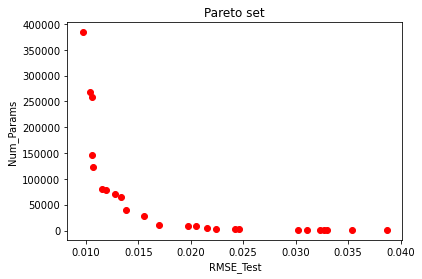

In [31]:
import matplotlib.pyplot as plt
a=res.F
plt.scatter(a[:,0],a[:,1], color="red")
plt.xlabel('RMSE_Test')
#plt.xticks(np.arange(0,0.2))
plt.ylabel('Num_Params')
plt.title('Pareto set')

### Selected models

In [32]:
from torchsummary import summary
evalu_fun(train_data,valid_data,test_data,k=3,growth_rate=10,x=2,x1=1,x2=1,x3=1,x4=0)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 4, 200, 200]             144
       BatchNorm2d-2          [-1, 4, 200, 200]               8
              ReLU-3          [-1, 4, 200, 200]               0
            Conv2d-4         [-1, 10, 200, 200]           1,960
        conv_layer-5         [-1, 14, 200, 200]               0
       BatchNorm2d-6         [-1, 14, 200, 200]              28
              ReLU-7         [-1, 14, 200, 200]               0
            Conv2d-8         [-1, 10, 200, 200]           6,860
        conv_layer-9         [-1, 24, 200, 200]               0
      Dense_block-10         [-1, 24, 200, 200]               0
      BatchNorm2d-11         [-1, 24, 200, 200]              48
             ReLU-12         [-1, 24, 200, 200]               0
           Conv2d-13         [-1, 12, 200, 200]             288
      BatchNorm2d-14         [-1, 12, 2

Epoch 0: , Train RMSE: 0.39609647309293555,Validation RMSE: 0.35399449989658205
Epoch 0: , Train loss: 5171174.03125,Validation loss: 501248.423828125
Epoch 1: , Train RMSE: 0.21119004709394518,Validation RMSE: 0.18994342322997212
Epoch 1: , Train loss: 1470056.73828125,Validation loss: 144314.01611328125
Epoch 2: , Train RMSE: 0.10532545650016029,Validation RMSE: 0.10724727202104971
Epoch 2: , Train loss: 365640.1708984375,Validation loss: 46007.909423828125
Epoch 3: , Train RMSE: 0.07284425627992105,Validation RMSE: 0.08501588542823325
Epoch 3: , Train loss: 174895.17578125,Validation loss: 28910.803100585938
Epoch 4: , Train RMSE: 0.06001269629011795,Validation RMSE: 0.08561882836591467
Epoch 4: , Train loss: 118706.2216796875,Validation loss: 29322.335083007812
Epoch 5: , Train RMSE: 0.051214621796692165,Validation RMSE: 0.0869009322947194
Epoch 5: , Train loss: 86452.01953125,Validation loss: 30207.088134765625
Epoch 6: , Train RMSE: 0.045170477744276315,Validation RMSE: 0.0874132

Epoch 52: , Train RMSE: 0.01776660837725009,Validation RMSE: 0.017910442107903123
Epoch 52: , Train loss: 10403.902221679688,Validation loss: 1283.1357460021973
Epoch 53: , Train RMSE: 0.017623464358669905,Validation RMSE: 0.017769723652594466
Epoch 53: , Train loss: 10236.930908203125,Validation loss: 1263.0523147583008
Epoch 54: , Train RMSE: 0.017486794577831845,Validation RMSE: 0.017639371085730632
Epoch 54: , Train loss: 10078.77197265625,Validation loss: 1244.5896492004395
Epoch 55: , Train RMSE: 0.017353438073286605,Validation RMSE: 0.017533724605101074
Epoch 55: , Train loss: 9925.634155273438,Validation loss: 1229.7259941101074
Epoch 56: , Train RMSE: 0.01722465056904658,Validation RMSE: 0.01743244732355201
Epoch 56: , Train loss: 9778.855834960938,Validation loss: 1215.560878753662
Epoch 57: , Train RMSE: 0.01709874210304219,Validation RMSE: 0.017316070326204303
Epoch 57: , Train loss: 9636.415710449219,Validation loss: 1199.385166168213
Epoch 58: , Train RMSE: 0.016972322059

Epoch 104: , Train RMSE: 0.013352209790457863,Validation RMSE: 0.013769176635504629
Epoch 104: , Train loss: 5876.158447265625,Validation loss: 758.3609008789062
Epoch 105: , Train RMSE: 0.0132619866362739,Validation RMSE: 0.013690906048615148
Epoch 105: , Train loss: 5797.014343261719,Validation loss: 749.7636337280273
Epoch 106: , Train RMSE: 0.013132056333641546,Validation RMSE: 0.013344157264086933
Epoch 106: , Train loss: 5683.981781005859,Validation loss: 712.2661323547363
Epoch 107: , Train RMSE: 0.013041998479302328,Validation RMSE: 0.0134967264515677
Epoch 107: , Train loss: 5606.289154052734,Validation loss: 728.6464996337891
Epoch 108: , Train RMSE: 0.013026001175682889,Validation RMSE: 0.013391911376983477
Epoch 108: , Train loss: 5592.544250488281,Validation loss: 717.373161315918
Epoch 109: , Train RMSE: 0.013018142040839169,Validation RMSE: 0.013521028318404979
Epoch 109: , Train loss: 5585.7978515625,Validation loss: 731.2728271484375
Epoch 110: , Train RMSE: 0.01293914

(0.010759183686854822, 436411)

In [31]:
from torchsummary import summary
evalu_fun(train_data,valid_data,test_data,k=1,growth_rate=19,x=1,x1=0,x2=1,x3=0,x4=0)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 4, 200, 200]             144
       BatchNorm2d-2          [-1, 4, 200, 200]               8
              ReLU-3          [-1, 4, 200, 200]               0
            Conv2d-4         [-1, 19, 200, 200]             684
        conv_layer-5         [-1, 23, 200, 200]               0
       BatchNorm2d-6         [-1, 23, 200, 200]              46
              ReLU-7         [-1, 23, 200, 200]               0
            Conv2d-8         [-1, 19, 200, 200]           3,933
        conv_layer-9         [-1, 42, 200, 200]               0
      Dense_block-10         [-1, 42, 200, 200]               0
      BatchNorm2d-11         [-1, 42, 200, 200]              84
             ReLU-12         [-1, 42, 200, 200]               0
           Conv2d-13         [-1, 21, 200, 200]             882
      BatchNorm2d-14         [-1, 21, 2

Epoch 0: , Train RMSE: 0.3709196643917574,Validation RMSE: 0.41061354447966797
Epoch 0: , Train loss: 4534682.859375,Validation loss: 674413.931640625
Epoch 1: , Train RMSE: 0.14649832376953092,Validation RMSE: 0.17957644054286986
Epoch 1: , Train loss: 707379.572265625,Validation loss: 128990.7919921875
Epoch 2: , Train RMSE: 0.08463320015923845,Validation RMSE: 0.0874480293483739
Epoch 2: , Train loss: 236085.181640625,Validation loss: 30588.63134765625
Epoch 3: , Train RMSE: 0.06774813215371646,Validation RMSE: 0.08680733633373058
Epoch 3: , Train loss: 151280.1181640625,Validation loss: 30142.054565429688
Epoch 4: , Train RMSE: 0.057284548939914914,Validation RMSE: 0.08794920634507462
Epoch 4: , Train loss: 108158.88427734375,Validation loss: 30940.251586914062
Epoch 5: , Train RMSE: 0.05029889633480848,Validation RMSE: 0.08834504522258653
Epoch 5: , Train loss: 83388.10693359375,Validation loss: 31219.388061523438
Epoch 6: , Train RMSE: 0.043828555454021624,Validation RMSE: 0.0881

Epoch 52: , Train RMSE: 0.018773158219094664,Validation RMSE: 0.019737363804932555
Epoch 52: , Train loss: 11616.141235351562,Validation loss: 1558.2541198730469
Epoch 53: , Train RMSE: 0.01888412100000697,Validation RMSE: 0.02040243681583874
Epoch 53: , Train loss: 11753.866455078125,Validation loss: 1665.037712097168
Epoch 54: , Train RMSE: 0.019336956270050363,Validation RMSE: 0.021491767637921096
Epoch 54: , Train loss: 12324.333251953125,Validation loss: 1847.5843048095703
Epoch 55: , Train RMSE: 0.019696625787099534,Validation RMSE: 0.0192298541981074
Epoch 55: , Train loss: 12787.06494140625,Validation loss: 1479.149169921875
Epoch 56: , Train RMSE: 0.01893422413198858,Validation RMSE: 0.020772993377838746
Epoch 56: , Train loss: 11816.319641113281,Validation loss: 1726.0690155029297
Epoch 57: , Train RMSE: 0.019210380257089786,Validation RMSE: 0.0193812224701923
Epoch 57: , Train loss: 12163.515869140625,Validation loss: 1502.5271377563477
Epoch 58: , Train RMSE: 0.018743386988

Epoch 104: , Train RMSE: 0.014125393463876661,Validation RMSE: 0.015077655749356999
Epoch 104: , Train loss: 6576.4013671875,Validation loss: 909.3428115844727
Epoch 105: , Train RMSE: 0.014087799983592093,Validation RMSE: 0.014642581935117301
Epoch 105: , Train loss: 6541.442932128906,Validation loss: 857.6208229064941
Epoch 106: , Train RMSE: 0.014004477456866065,Validation RMSE: 0.014433935774078975
Epoch 106: , Train loss: 6464.292816162109,Validation loss: 833.3540077209473
Epoch 107: , Train RMSE: 0.013848140263610946,Validation RMSE: 0.014367606741351223
Epoch 107: , Train loss: 6320.771789550781,Validation loss: 825.7124938964844
Epoch 108: , Train RMSE: 0.01375196781201558,Validation RMSE: 0.014167372083865636
Epoch 108: , Train loss: 6233.283752441406,Validation loss: 802.8577270507812
Epoch 109: , Train RMSE: 0.01358977801377674,Validation RMSE: 0.013867659749331095
Epoch 109: , Train loss: 6087.120910644531,Validation loss: 769.2479476928711
Epoch 110: , Train RMSE: 0.01349

(0.012149072170544652, 342698)

In [1]:
########################################################################
#########################################################################

In [3]:
B=np.array([[1.04534897e-02, 3.42698000e+05],
       [1.95530642e-02, 1.21760000e+04],
       [2.38634139e-02, 3.02600000e+03],
       [9.88223311e-03, 1.16167200e+06],
       [1.68375230e-02, 3.35200000e+04],
       [1.03049298e-02, 1.15408500e+06],
       [1.55876648e-02, 4.40290000e+04],
       [1.36610569e-02, 1.11325000e+05],
       [1.97765148e-02, 1.20030000e+04],
       [2.66066761e-02, 2.38400000e+03],
       [1.66556806e-02, 3.84300000e+04],
       [1.84929561e-02, 1.58960000e+04],
       [1.36604024e-02, 1.37773000e+05],
       [2.04542299e-02, 8.57800000e+03],
       [3.83915624e-02, 1.01200000e+03],
       [2.79909238e-02, 2.16600000e+03],
       [2.32561915e-02, 6.63800000e+03],
       [1.18050268e-02, 2.69061000e+05],
       [2.81069512e-02, 1.81200000e+03],
       [3.18072676e-02, 1.39000000e+03],
       [1.20447973e-02, 1.48558000e+05],
       [1.90524354e-02, 1.33160000e+04],
       [3.38766967e-02, 1.29400000e+03],
       [1.75316066e-02, 2.60970000e+04],
       [1.24759808e-02, 1.46722000e+05],
       [1.39693812e-02, 5.85420000e+04],
       [3.57105693e-02, 1.16800000e+03],
       [1.15170502e-02, 3.14378000e+05]])

In [2]:
A=np.array([[2.18777417e-02, 3.47542000e+05],
       [5.10757998e-02, 1.45800000e+03],
       [4.19581472e-02, 1.81200000e+03],
       [2.35066070e-02, 2.37533000e+05],
       [2.44868917e-02, 1.68762000e+05],
       [2.31570056e-02, 3.07063000e+05],
       [2.44701033e-02, 2.03498000e+05],
       [2.86211836e-02, 4.59140000e+04],
       [2.56780531e-02, 1.09990000e+05],
       [2.65491290e-02, 7.90180000e+04],
       [2.21539980e-02, 3.08619000e+05],
       [3.38182939e-02, 1.20030000e+04],
       [3.02249377e-02, 2.15410000e+04],
       [3.76529543e-02, 3.02600000e+03],
       [3.58561627e-02, 5.83000000e+03],
       [3.01157378e-02, 2.15800000e+04],
       [5.24906523e-02, 1.01200000e+03],
       [2.48055085e-02, 1.22494000e+05],
       [2.80469888e-02, 6.11390000e+04],
       [3.00628942e-02, 3.16610000e+04]])